# Sysarmy - Predicción de sueldos - 2019.1

## Objetivo

Generar modelos para establecer un sueldo dadas las otras respuestas a las preguntas de la encuesta de sysarmy.

## Metodología

Primero vamos a ver qué respuestas tenemos a cada pregunta independientemente. Esta primera exploración nos da una impresión de los datos disponibles, los posibles outliers (respuestas atípicas), qué datos están desbalanceados (tienen mucha asimetría en las respuestas, por ejemplo muy poca gente de Catamarca responde).

Después vamos a ver cuál es el sueldo promedio y la variabilidad de cada respuesta usando _boxplot_.

Luego generaremos modelos simplificados con una pequeña muestra para entender cómo funcionan. Los modelos a generar serán LinearRegression, KNN, Random Forest, xgboost y CatBoost.

La mayoría de las preguntas, sino todas, son de respuestas de tipo categóricas. Esto suele ser difícil de manejar para modelos de Machine Learning porque se necesita llevar todos los valores a un mismo espacio, es decir, poder establecer un grado de similitud entre un hombre en Jujuy y un hombre en Santa Fe o una mujer en Jujuy. Lo que vamos a hacer para pasar estas columnas a valores numéricos es el promedio de sueldos para ese valor en nuestra muestra de entrenamiento.

Aplicaremos cross validation con 5 folds y usaremos r2 como métrica.

Una vez entrenado el modelo, buscaremos outliers viendo las observaciones que más difieren de lo esperado y vemos si querremos excluirlas.

In [1]:
import pandas as pd

df = pd.read_csv('2019.1 - Encuesta de remuneración salarial - Argentina.csv', skiprows=3)
df

,Me identifico,Tengo,Dónde estás trabajando,Años de experiencia,Años en la empresa actual,Años en el puesto actual,¿Gente a cargo?,Nivel de estudios alcanzado,Estado,Carrera,...,Orientación sexual,¿Tenés algún tipo de discapacidad?,¿Sentís que esto te dificultó el conseguir trabajo?,¿A qué eventos de tecnología asististe en el último año?,Cantidad de empleados,Actividad principal,¿La recomendás como un buen lugar para trabajar?,¿Cómo calificás las políticas de diversidad e inclusión?,¿A cuántos kilómetros de tu casa queda la oficina?,Beneficios extra
0,Hombre,22,Catamarca,2.0,1.0,1.0,0,Universitario,En curso,ING informática,...,Heterosexual,NaN,NaN,NaN,1001-2000,Producto basado en Software,8,9,2.0,Capacitaciones y/o cursos
1,Hombre,23,Catamarca,2.0,1.0,1.0,0,Secundario,Completado,Ing informática,...,Heterosexual,NaN,NaN,Charlas online,51-100,Producto basado en Software,8,10,2.0,"Capacitaciones y/o cursos, Licencia de paterni..."
2,Mujer,35,Chaco,8.0,7.0,2.0,2,Posgrado,En curso,MTI,...,dgsdg,NaN,No,varios,201-500,Otras industrias,4,4,0.2,"Capacitaciones y/o cursos, Licencia de paterni..."
3,Hombre,41,Chaco,20.0,2.0,10.0,0,Universitario,Completado,Lic en sistemas,...,Heterosexual,NaN,NaN,Ninguno,1-10,Servicios / Consultoría de Software / Digital,5,1,-1.0,"Horarios flexibles, Vacaciones flexibles (adic..."
4,Hombre,35,Chaco,5.0,3.0,2.0,0,Universitario,Completado,Analisis en Sistemas,...,Heterosexual,NaN,No,NaN,501-1000,Producto basado en Software,8,8,1.0,"Capacitaciones y/o cursos, Clases de idiomas, ..."
5,Hombre,38,Chaco,16.0,16.0,16.0,0,Terciario,Incompleto,Analista de Sistemas,...,Heterosexual,NaN,No,Ninguno,201-500,Otras industrias,6,4,2.0,Ninguna de las anteriores
6,Hombre,30,Chaco,9.0,5.0,5.0,3,Terciario,Completado,T S P,...,Heterosexual,NaN,No,NaN,201-500,Otras industrias,6,10,2.0,"Abono de celular y/o Internet, Comidas pagas/s..."
7,Hombre,32,Chaco,10.0,2.0,2.0,0,Universitario,Incompleto,Ing. en Sistemas,...,Heterosexual,NaN,NaN,Ninguno :(,1001-2000,Otras industrias,5,5,5.0,Ninguna de las anteriores
8,Hombre,28,Chaco,7.0,3.0,1.0,2,Universitario,Incompleto,Ingeniería en Sistemas,...,Heterosexual,NaN,No,NaN,51-100,Servicios / Consultoría de Software / Digital,10,5,-1.0,"Horarios flexibles, Vacaciones flexibles (adic..."
9,Hombre,29,Chaco,0.0,0.0,0.0,0,Universitario,En curso,Ingenieria en Sistemas,...,Heterosexual,NaN,No,NaN,501-1000,Producto basado en Software,5,5,3.0,Capacitaciones y/o cursos


## Gráficos de respuestas

Vamos a ver las respuestas a cada una de las preguntas. Esto nos puede ayudar a tener una idea de qué tipo de respuestas se obtuvieron a grandes rasgos, como si la mayoría de la gente era hombre o vivía en la Ciudad Autónoma de Buenos Aires. También nos puede ayudar a detectar valores anómales, como gente de 200 años.

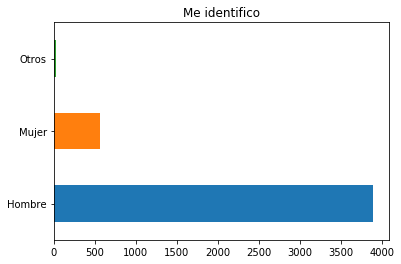

In [2]:
%matplotlib inline
df['Me identifico'].value_counts().plot.barh(title='Me identifico');

Ahora veamos la edad agrupando cada 5 años.

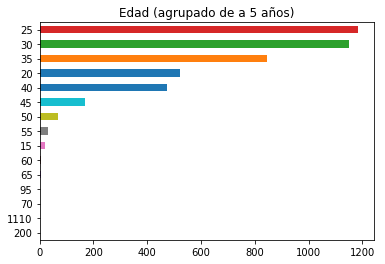

In [3]:
df['Tengo'].apply(lambda x: 5 * (x // 5)).value_counts(sort=True, ascending=True).plot.barh(title='Edad (agrupado de a 5 años)');

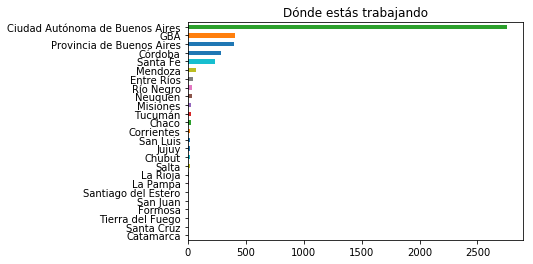

In [4]:
df['Dónde estás trabajando'].value_counts(sort=True, ascending=True).plot.barh(title='Dónde estás trabajando');

Veamos la cantidad de años de trabajo que tiene la gente agrupadas cada tres años para mejorar la visualización.

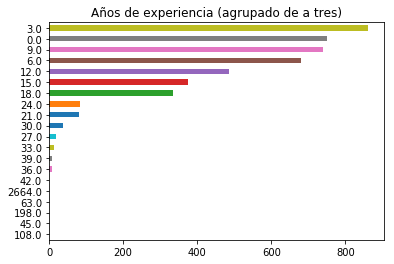

In [5]:
df['Años de experiencia'].apply(lambda x: 3 * (x // 3)).value_counts(sort=True, ascending=True).tail(20).plot.barh(title='Años de experiencia (agrupado de a tres)');

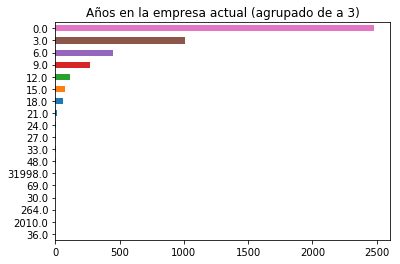

In [6]:
df['Años en la empresa actual'].apply(lambda x: 3 * (x // 3)).value_counts(sort=True, ascending=True).tail(20).plot.barh(title='Años en la empresa actual (agrupado de a 3)');

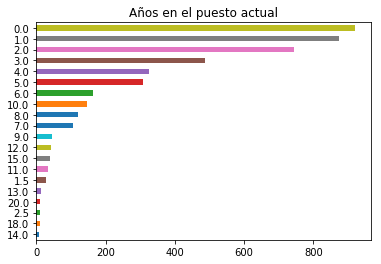

In [7]:
df['Años en el puesto actual'].value_counts(sort=True, ascending=True).tail(20).plot.barh(title='Años en el puesto actual');

La mayoría de la gente parece haber estado menos de 5 años en su trabajo actual.

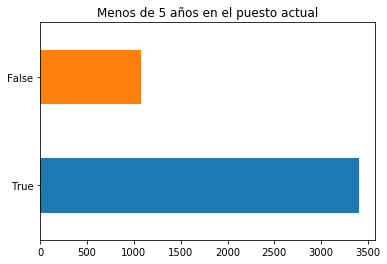

In [8]:
(df['Años en el puesto actual'] < 5).value_counts().plot.barh(title='Menos de 5 años en el puesto actual');

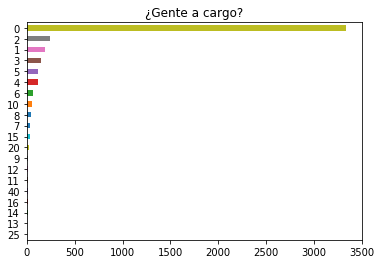

In [9]:
df['¿Gente a cargo?'].value_counts(sort=True, ascending=True).tail(20).plot.barh(title='¿Gente a cargo?');

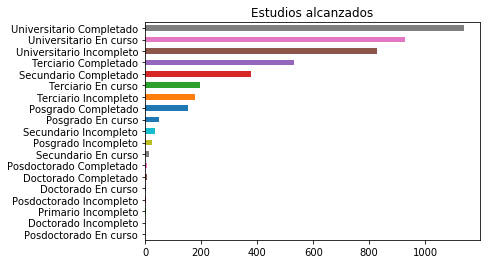

In [10]:
df.apply(lambda row: '{} {}'.format(row['Nivel de estudios alcanzado'], row['Estado']), axis=1).value_counts(sort=True, ascending=True).tail(20).plot.barh(title='Estudios alcanzados');

In [11]:
import re #ahre
regex_replace_map = {
    '^(Ing\.?|In?geni?[ea]r([íi]a|a|o))( en| de|) (.*)$': 'Ingeniería en \\4',
    '^(Ing\.?|Ingeni?er([íi]a|a|o|))$': 'Ingeniería',
    '^[LI]ic(enciatura|enciad[ao]|\.|)( en| de|) (.*)$': 'Licenciatura en \\3',
    '^Analistas?( de| en) (.*)$': 'Analista de \\2',
    '^(Tec\.? |T[eé]cnic(atura|a|o))(.*)$': 'Tecnicatura\\3',
    '^(Dr\.?|Doctor(ado|a|))( en| de|) (.*)$': 'Doctorado en \\4',
    '^Contador(a|).*$': 'Contador Público',
    '^Programador(a|).*$': 'Programación',
    '^(Abocac[íi]a|abogad[ao])$': 'Abogacía',
    '^(.*)ing[\. ](.+)$': '\\1Ingeniería \\2',
    '^(.*)lic[\. ](.+)$': '\\1Licenciatura \\2',
    '^(.*)(mg|mag|magister|maestr[íi]a)[\. ](.+)$': '\\1Maestría \\3',
    '^(.*)informaci[óo]n(.*)$': '\\1Información\\2',
    '^(.*)computaci[óo]n(.*)$': '\\1Computación\\2',
    '^(.*)inform[áàa]tica(.*)$': '\\1Informática\\2',
    '^(.*)programaci[óo]n(.*)$': '\\1Programación\\2',
    '^(.*)licenciatura(.*)$': '\\1Licenciatura\\2',
    '^(.*)electr[óo]nica(.*)$': '\\1Electrónica\\2',
    '^(.*)el[ée]ctrica(.*)$': '\\1Eléctrica\\2',
    '^(.*)tecnolog[íi]a(.*)$': '\\1Tecnología\\2',
    '^(.*)administraci[óo]n(.*)$': '\\1Administración\\2',
    '^(.*)sistem[as]s(.*)$': '\\1Sistemas\\2',
    '^(.*)ingeniero[as](.*)$': '\\1Ingeniería\\2',
    '^(.*)analista(.*)$': '\\1Analista\\2',
    '^(.*)(adm|admin)[ \.](.*)$': '\\1Administración \\2',
    '^(.*)inform[aá]ticos(.*)$': '\\1Informáticos\\2',
    '^(.*)liciencia(.*)$': '\\1licencia\\2', # OMG!
    '^(.*)ciencias?(.*)$': '\\1Ciencias\\2',
    '^(.*)cs\.?(.+)$': '\\1Ciencias\\2',
    '^(.*)an[áàa]lisis(.*)$': '\\1Análisis\\2',
    '^(.*)gesti[óo]n(.*)$': '\\1Gestión\\2',
    '^(.*)ux(.*)$': '\\1UX\\2',
    '^(.*)superior(.*)$': '\\1Superior\\2',
    '^(.*)rrhh(.*)$': '\\1Recursos Humanos\\2',
    '^(.*)empresa(.*)$': '\\1Empresa\\2',
    '^(.*)im[áa]gen(.*)$': '\\1Imágen\\2',
    '^(.*)sonido(.*)$': '\\1Sonido\\2',
    '^(.*)diseño(.*)$': '\\1Diseño\\2',
    '^(.*)electr[óo]nico(.*)$': '\\1Electrónico\\2',
    '^(.*)seguridad(.*)$': '\\1Seguridad\\2',
    '^(.*)higiene(.*)$': '\\1Higiene\\2',
    '^(.*)mec[áa]nica(.*)$': '\\1Mecánica\\2',
    '^(.*)telecomunicaciones(.*)$': '\\1Telecomunicaciones\\2',
    '^(.*)teleinform[áa]tica(.*)$': '\\1Teleinformática\\2',
    '^(.*)industrial(.*)$': '\\1Industrial\\2',
    '^(.*)universitari(.*)$': '\\1Universitari\\2',
    '^(.*)gr[áa]fico(.*)$': '\\1Gráfico\\2',
    '^(.*)desarrollo(.*)$': '\\1Desarrollo\\2',
    '^(.*)software(.*)$': '\\1Software\\2',
    '^(.*)social(.*)$': '\\1Social\\2',
    '^traductor(a|ado|)( P[úu]blico| de .+)?$': 'Traductorado Público',
    '^(.*)p[úu]blico(.*)$': '\\1Público\\2',
    '^(.*)trabajo(.*)$': '\\1Trabajo\\2',
    '^(.*)sitio(.*)$': '\\1Sitio\\2',
    '^(.*)filosof[íi]a(.*)$': '\\1Filosofía\\2',
    '^(.*)redes(.*)$': '\\1Redes\\2',
    '^(.*)psicolog[íi]a(.*)$': '\\1Psicología\\2',
    '^(.*)programador(.*)$': '\\1Programador\\2',
    '^(.*)biom[ée]dic(.*)$': '\\1Biomédic\\2',
    '^(.*)web(.*)$': '\\1Web\\2',
    '^(.*)arte(.*)$': '\\1Arte\\2',
    '^(.*)dela(.*)$': '\\1de la\\2',
    '^(.*)en en(.*)$': '\\1 en \\2',
    '^(.*) de (.*)$': '\\1 de \\2',
    '^(.*) en (.*)$': '\\1 en \\2',
    '^(.*)comunica(dor|dora|ci[óo]n)(.*)$': '\\1Comunicación\\3',
    '^(.*)telecomunicaci[óo]n(es)?(.*)$': '\\1Telecomunicaciones\\3',
    '^(.*)visual(.*)$': '\\1Visual\\2',
    '^fot[óo]graf(a|o|ia|ía)$': 'Fotografía',
    '^(.*)  (.*)$': '\\1 \\2',
    '^(TSP|T S P|T\.S\.P\.?)$': 'Tecnicatura Superior en Programación',
    '^(TSU|T S U|T\.S\.U\.?)(.*)$': 'Tecnicatura Superior Universitaria\\2',
    '^(ISI|I S I|I\.S\.I\.?)$': 'Ingeniería en Sistemas de Información',
    '^(.*)T\.? sup[\.](.*)$': '\\1Tecnicatura Superior\\2',
    '^(Tecnicatura|Ingeniería)( en | )(Industrial|Civil|Electrónic[ao]|Biom[ée]dica|Eléctrica|Mecánica)$': '\\1 \\3',
    '^(Tecnicatura|Ingeniería) Electrónic[ao]$': '\\1 Electrónica',
    '^(Ingeniería|Licenciatura) en Sistemas?(| de Información| en Información| de la Información| Inform[áa]ticos)$': '\\1 en Sistemas de Información',
    '^(.*)Superior Programación(.*)$': '\\1Superior en Programación\\2',
    '^(.*)Tecnicatura Universitario(.*)$': '\\1Tecnicatura Universitaria\\2',
    '^(.*)Tecnicaturaen(.*)$': '\\1Tecnicatura en\\2',
    '^(.*)TecnicaturaSuperior(.*)$': '\\1Tecnicatura Superior\\2',
    '^(.*)TecnicaturaProgramación(.*)$': '\\1Tecnicatura en Programación\\2',
    '^Tecnicatura Programador(.*)$': 'Tecnicatura en Programación',
    '^(LCC|Ciencias Computación|Licenciatura en Computación|Ciencias de la Computación)$': 'Licenciatura en Ciencias de la Computación',
    '^(An[áa]lisis de Sistemas?|Analista( de|) Sistemas?).*$': 'Analista de Sistemas',
    '^(Diseñ(o|ador|adora) Multimedial?|Multimedia)$': 'Diseño Multimedial',
    '^(.*)Universitario en Sistemas(.*)$': '\\1Universitario de Sistemas\\2',
    '^(.*)\.$': '\\1',
}
for regex, pattern in regex_replace_map.items():
    compiled_regex = re.compile(regex, re.I)
    df['Carrera'] = df['Carrera'].str.strip().str.replace(compiled_regex, pattern)

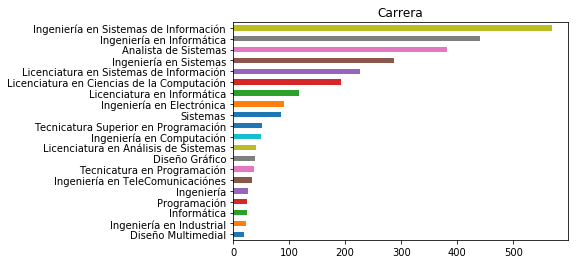

In [12]:
df['Carrera'].value_counts(sort=True, ascending=True).tail(20).plot.barh(title='Carrera');

In [13]:
regex_replace_map = {
    '(UTN|UTN .*|UTN ?F.*|Universidad Tec?nol[óo]gica Nacional( F.*)?)$': 'UTN',
    '(UBA|FIUBA|FCE-?UBA|Universidad de Buenos Aires|Buenos Aires)$': 'UBA',
    '(UNLP|Universidad Nacional de La Plata)$': 'UNLP',
    '(UNLaM|Universidad( Nacional|) de la Matanza|la matanza)$': 'UNLaM',
    '(UNS|Universidad Nacional del Sur)$': 'UNS',
    '(UNICEN|Universidad Nacional del Centro( de la (Provincia|Pcia\.?) de Buenos Aires)?)$': 'UNICEN',
    '(UNC|Universidad Nacional de C[óo]rdoba)$': 'UNC',
    '(UNRC|Universidad Nacional de R[ií]o Cuarto)$': 'UNRC',
    '(UNQ|Universidad Nacional de Quilmes|Unqui)$': 'UNQ',
    '(UADE|Universidad Argentina de la Empresa)$': 'UADE',
    '(UB|Universidad de Belgrano)$': 'UB',
    '(UK|(Universidad )?Kennedy)$': 'UK',
    '(UCES|Universidad de Ciencias Empresariales y Sociales)$': 'UCES',
    '(UM|Universidad de Mor[óo]n|Mor[óo]n)$': 'UM',
    '(UP|Universidad de Palermo|Palermo)$': 'UP',
    '(CAECE|UCAECE|Universidad CAECE)$': 'CAECE',
    '(ORT|ORT Argentina)$': 'ORT',
    '(UAI|(Universidad )?Abierta Interamericana)$': 'UAI',
    '(UBP|(Universidad )?Blas Pascal)$': 'UBP',
    '(Universidad )?(Maim[óo]nides)$': 'Maimónides',
    '(UNLA|.*Lan[úu]s)$': 'UNLA',
    '(UNL|(Universidad )?Nacional del Litoral)$': 'UNL',
    '(UNLu|Universidad Nacional de Luj[áa]n)$': 'UNLu',
    '((Escuela .?)?(Multimedial? )?)?Da ?Vinci$': 'DaVinci',
    '(Universidad )?(Siglo 21|Siglo XXI)$': 'Siglo 21',
    '(UA|(Universidad )?Austral)$': 'UNL',
    '(UA|(Universidad )?Austral)$': 'UNL',
    '(Istea)$': 'ISTEA',
    '(UAP|Universidad Adventista del Plata)': 'UAP',
    '(UNJu|Universidad Nacional de Jujuy)': 'UNJu',
    '(UNCUYO|Universidad Nacional de Cuyo)': 'UNCUYO',
    '(ISSD|Instituto Superior Santo Domingo)': 'ISSD',
    '(UNSAM|Universidad Nacional de San Mart[ií]n)': 'UNSAM',
    '(UNLAR|Universidad Nacional de La Rioja)': 'UNLaR',
    '(UNCOMA|Universidad Nacional del Comahue)': 'UNCOMA',
    '(UDA|Universidad del Aconcagua)': 'UDA',
    '(IUA|Instituto Universitario Aeronautico)': 'IUA',
    '(-)$': 'DELETEME',
}
for regex, pattern in regex_replace_map.items():
    compiled_regex = re.compile(regex, re.I)
    df['Universidad'] = df['Universidad'].str.strip().str.replace(compiled_regex, pattern)

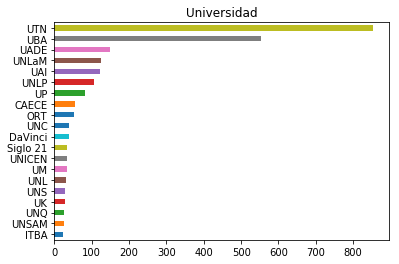

In [14]:
df['Universidad'].value_counts(sort=True, ascending=True).tail(20).plot.barh(title='Universidad');

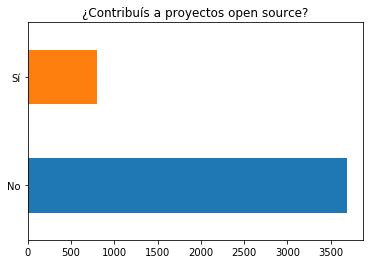

In [15]:
df['¿Contribuís a proyectos open source?'].value_counts().plot.barh(title='¿Contribuís a proyectos open source?');

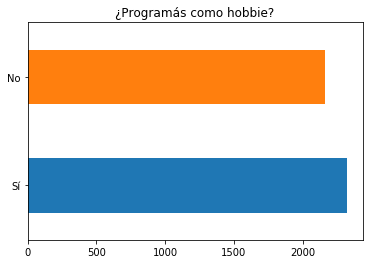

In [16]:
df['¿Programás como hobbie?'].value_counts().plot.barh(title='¿Programás como hobbie?');

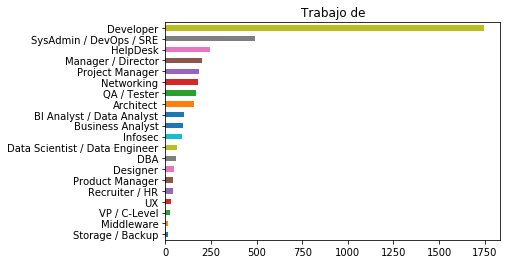

In [17]:
df['Trabajo de'].value_counts(sort=True, ascending=True).tail(20).plot.barh(title='Trabajo de');

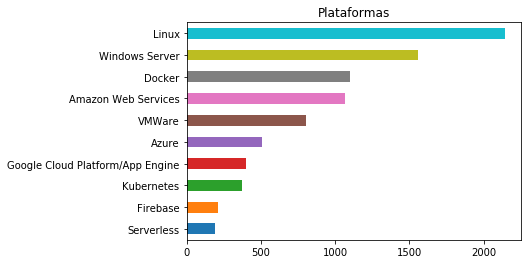

In [18]:
tech_count = {}
for x in df['Plataformas'].dropna():
    for key in x.split(','):
        key = key.strip()
        tech_count[key] = tech_count.get(key, 0) + 1
pd.Series(tech_count).sort_values(ascending=True).tail(10).plot.barh(title='Plataformas');

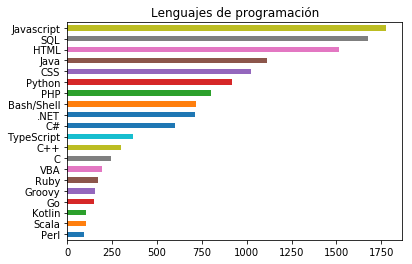

In [19]:
languages_count = {}
for x in df['Lenguajes de programación'].dropna():
    for key in x.split(','):
        key = key.strip()
        languages_count[key] = languages_count.get(key, 0) + 1
pd.Series(languages_count).sort_values(ascending=True).tail(20).plot.barh(title='Lenguajes de programación');

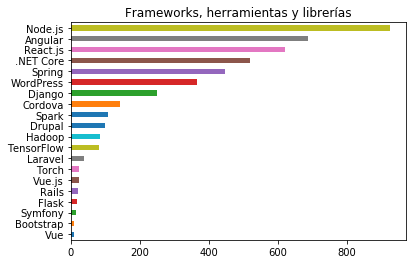

In [20]:
fw_count = {}
for x in df['Frameworks, herramientas y librerías'].dropna():
    for key in x.split(','):
        key = key.strip()
        fw_count[key] = fw_count.get(key, 0) + 1
pd.Series(fw_count).sort_values(ascending=True).tail(20).plot.barh(title='Frameworks, herramientas y librerías');

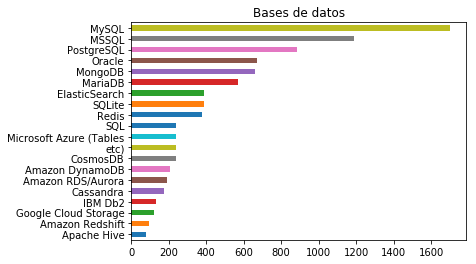

In [21]:
db_count = {}
for x in df['Bases de datos'].dropna():
    for key in x.split(','):
        key = key.strip()
        db_count[key] = db_count.get(key, 0) + 1
pd.Series(db_count).sort_values(ascending=True).tail(20).plot.barh(title='Bases de datos');

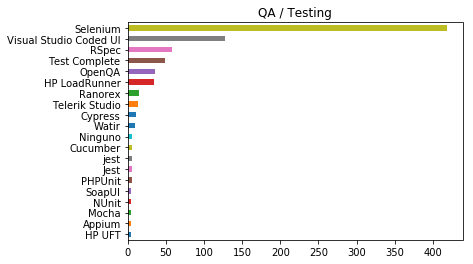

In [22]:
qat_count = {}
for x in df['QA / Testing'].dropna():
    for key in x.split(','):
        key = key.strip()
        qat_count[key] = qat_count.get(key, 0) + 1
pd.Series(qat_count).sort_values(ascending=True).tail(20).plot.barh(title='QA / Testing');

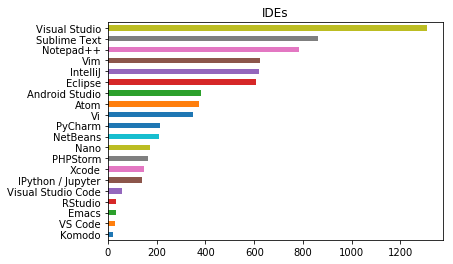

In [23]:
ide_count = {}
for x in df['IDEs'].dropna():
    for key in x.split(','):
        key = key.strip()
        ide_count[key] = ide_count.get(key, 0) + 1
pd.Series(ide_count).sort_values(ascending=True).tail(20).plot.barh(title='IDEs');

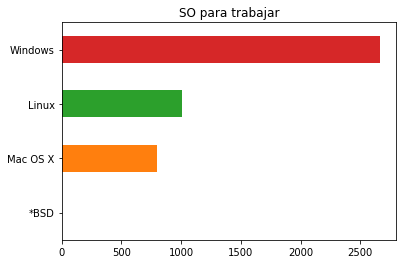

In [24]:
df['¿Qué SO usás en tu laptop/PC para trabajar?'].value_counts(sort=True, ascending=True).tail(20).plot.barh(title='SO para trabajar');

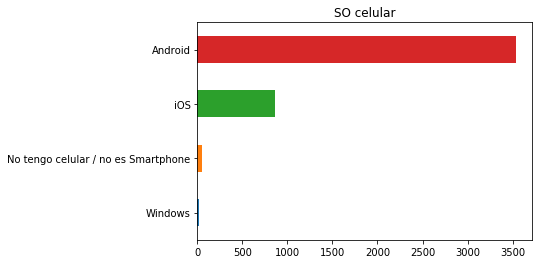

In [25]:
df['¿Y en tu celular?'].value_counts(sort=True, ascending=True).tail(20).plot.barh(title='SO celular');

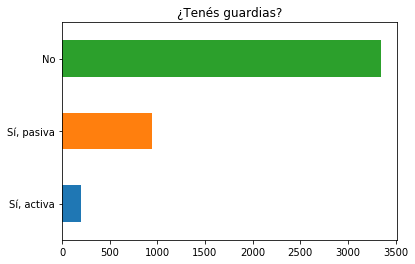

In [26]:
df['¿Tenés guardias?'].value_counts(sort=True, ascending=True).tail(20).plot.barh(title='¿Tenés guardias?');

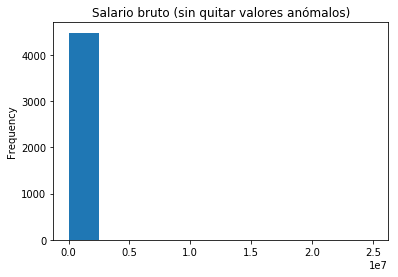

In [27]:
df['Salario mensual BRUTO (en tu moneda local)'].plot.hist(title='Salario bruto (sin quitar valores anómalos)');

In [28]:
df['Salario mensual BRUTO (en tu moneda local)'].sort_values().head()

1906    1.0
2124    1.0
43      1.0
2235    1.0
3916    1.0
Name: Salario mensual BRUTO (en tu moneda local), dtype: float64

In [29]:
df['Salario mensual BRUTO (en tu moneda local)'].sort_values().tail()

3274      931415.92
4029     1500000.00
2349     3572000.00
3169     5138262.00
3919    25000000.00
Name: Salario mensual BRUTO (en tu moneda local), dtype: float64

In [30]:
(df['Salario mensual BRUTO (en tu moneda local)'] < 10000).sum()

151

In [31]:
df[(df['Salario mensual BRUTO (en tu moneda local)'] < 12000) & (df['Salario mensual BRUTO (en tu moneda local)'] > 10000)]

,Me identifico,Tengo,Dónde estás trabajando,Años de experiencia,Años en la empresa actual,Años en el puesto actual,¿Gente a cargo?,Nivel de estudios alcanzado,Estado,Carrera,...,Orientación sexual,¿Tenés algún tipo de discapacidad?,¿Sentís que esto te dificultó el conseguir trabajo?,¿A qué eventos de tecnología asististe en el último año?,Cantidad de empleados,Actividad principal,¿La recomendás como un buen lugar para trabajar?,¿Cómo calificás las políticas de diversidad e inclusión?,¿A cuántos kilómetros de tu casa queda la oficina?,Beneficios extra
662,Mujer,20,Ciudad Autónoma de Buenos Aires,0.0,0.0,0.0,0,Universitario,En curso,Ingeniería en Sistemas de Información,...,Heterosexual,NaN,NaN,NaN,201-500,Servicios / Consultoría de Software / Digital,7,9,5.0,"Capacitaciones y/o cursos, Descuentos varios (..."
1075,Mujer,25,Ciudad Autónoma de Buenos Aires,0.0,0.0,0.0,0,Universitario,En curso,Ingeniería en Sistemas de Información,...,Heterosexual,NaN,NaN,Digital Summit 2018,1001-2000,Servicios / Consultoría de Software / Digital,8,9,9.0,"Capacitaciones y/o cursos, Descuentos varios (..."
1261,Mujer,21,Ciudad Autónoma de Buenos Aires,1.0,1.0,1.0,0,Universitario,En curso,Diseño Gráfico,...,Bisexual o queer,NaN,NaN,NaN,1-10,Producto basado en Software,8,1,8.0,"Horarios flexibles, Vacaciones flexibles (adic..."
1976,Hombre,26,Ciudad Autónoma de Buenos Aires,0.0,0.0,0.0,0,Terciario,Completado,Diseño Multimedial,...,Pansexual,NaN,No,NaN,1-10,Servicios / Consultoría de Software / Digital,5,5,5.0,Comidas pagas/subvencionadas
2393,Hombre,71,Ciudad Autónoma de Buenos Aires,20.0,3.0,20.0,0,Universitario,Incompleto,Ingeniería,...,Heterosexual,NaN,No,0,11-50,Otras industrias,2,2,5.0,Ninguna de las anteriores
2798,Hombre,22,Córdoba,1.0,1.0,1.0,0,Universitario,En curso,Ingeniería en Software,...,Heterosexual,NaN,NaN,PyData Córdoba,201-500,Otras industrias,6,7,9.6,"Capacitaciones y/o cursos, Descuentos varios (..."
2804,Hombre,20,Córdoba,1.0,1.0,1.0,0,Universitario,En curso,Ingeniería en Sistemas de Información,...,Heterosexual,NaN,NaN,Facebook Developers Circle CBA,11-50,Otras industrias,7,8,8.0,"Capacitaciones y/o cursos, Playroom"
2949,Hombre,38,Córdoba,5.0,5.0,5.0,0,Universitario,En curso,Ingeniería en TeleComunicaciónes,...,Heterosexual,NaN,NaN,NaN,51-100,Otras industrias,8,9,4.0,"Capacitaciones y/o cursos, Horarios flexibles"
3124,Hombre,32,Entre Ríos,5.0,4.0,4.0,2,Universitario,En curso,Licenciatura en Sistemas de Información,...,Heterosexual,NaN,No,Conferencias de Seguridad Informática,1-10,Producto basado en Software,6,6,12.0,Ninguna de las anteriores
3890,Hombre,28,Provincia de Buenos Aires,1.0,1.0,1.0,0,Universitario,Completado,Tecnicatura Superior en Programación,...,Heterosexual,NaN,NaN,NaN,1-10,Producto basado en Software,10,10,3.0,"Horarios flexibles, Vacaciones flexibles (adic..."


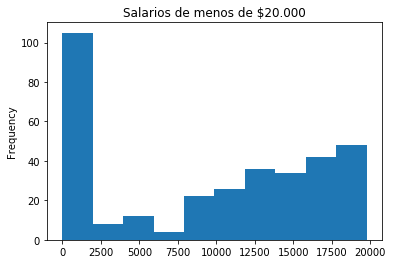

In [32]:
df[(df['Salario mensual BRUTO (en tu moneda local)'] < 20000)]['Salario mensual BRUTO (en tu moneda local)'].plot.hist(title='Salarios de menos de $20.000');

In [33]:
df['Salario mensual BRUTO (en tu moneda local)'].sort_values().tail(20)

59        330000.00
58        332200.00
409       340000.00
3694      356783.00
299       370000.00
500       370000.00
3192      370000.00
591       440000.00
2109      450000.00
3489      550000.00
4129      576000.00
746       600000.00
1274      600000.00
2387      630000.00
2489      720000.00
3274      931415.92
4029     1500000.00
2349     3572000.00
3169     5138262.00
3919    25000000.00
Name: Salario mensual BRUTO (en tu moneda local), dtype: float64

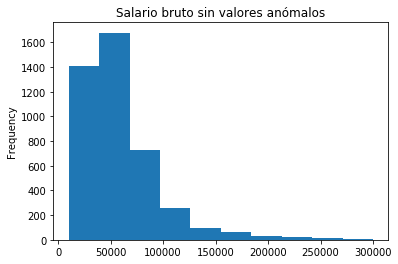

In [34]:
df[(df['Salario mensual BRUTO (en tu moneda local)'] >= 10000) & (df['Salario mensual BRUTO (en tu moneda local)'] <= 300000)]['Salario mensual BRUTO (en tu moneda local)'].plot.hist(title='Salario bruto sin valores anómalos');

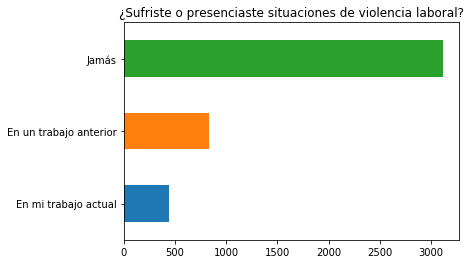

In [35]:
df['¿Sufriste o presenciaste situaciones de violencia laboral?'].value_counts(sort=True, ascending=True).tail(20).plot.barh(title='¿Sufriste o presenciaste situaciones de violencia laboral?');

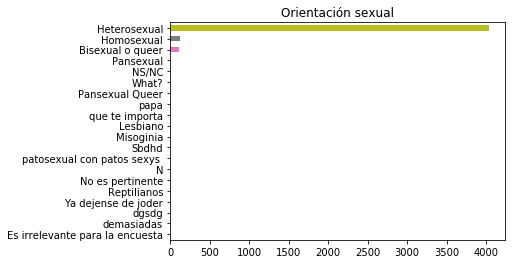

In [36]:
df['Orientación sexual'].value_counts(sort=True, ascending=True).tail(20).plot.barh(title='Orientación sexual');

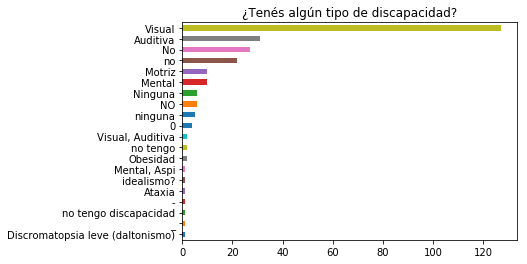

In [37]:
df['¿Tenés algún tipo de discapacidad?'].value_counts(sort=True, ascending=True).tail(20).plot.barh(title='¿Tenés algún tipo de discapacidad?');

'reduced in 0.586207'

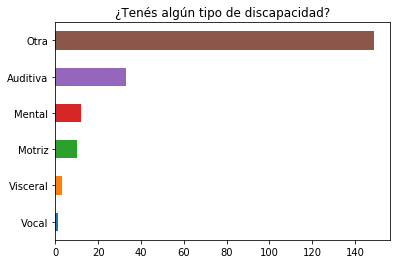

In [38]:
def normalize_dataframe_column(df_in, column_name, regex_assign_map):
  """
  Given a Dataframe (df), a column name that identifies the column to sanitize,
  applies an in-place replacement for each pair regex-value in the map
  """
  df_out = df_in.copy()
  for regex, value in regex_assign_map.items():
    compiled_regex = re.compile(regex, re.I)
    mask = df_in[ column_name ].str.strip().str.match(compiled_regex, na=False)
    df_out.loc[ mask, column_name ] = value
  
  # debug
  total, final = len(df_in[column_name].unique()), len(df_out[column_name].unique())
  display('reduced in {:02f}'.format((total - final) / total))
  return df_out

def normalize_dataframe_column_replace(df_in, column_name, regex_replace_map):
  """
  Given a Dataframe (df), a column name that identifies the column to sanitize,
  applies an in-place replacement for each pair regex-value in the map
  """
  df_out = df_in.copy()
  for regex, pattern in regex_replace_map.items():
    compiled_regex = re.compile(regex, re.I)
    df_out[ column_name ] = df_out[ column_name ].str.strip().str.replace(compiled_regex, pattern)
  
  # debug
  total, final = len(df_in[column_name].unique()), len(df_out[column_name].unique())
  display('reduced in {:02f}'.format((total - final) / total))
  return df_out

df = normalize_dataframe_column(df, '¿Tenés algún tipo de discapacidad?', {
    '^(_|-|no( tengo)?|ningun[oa]|nada|0|)$': None,
    '.*auditiv[oa].*': 'Auditiva',
    '.*visual.*': 'Visual',
    'mental': 'Mental',
    'motriz': 'Motriz',
    'vis?c?eral': 'Visceral',
    '^no, solo mala vista$': None,
    '^no tengo ninguna discapacidad$': None,
    '^tolerancia$': None,
    '^no tengo discapacidad$': None,
    r'^en serio\?$': None,
    r'^idealismo\?$': None,
    r'^si soy lagarto$': None,
    r'^windows$': None,
    r'^social$': None,
    r'^no les interesa$': None,
    r'^edad$': None,
    r'^ninguna \¿Habia que llenar esta respuesta\?$': None,
})
df['¿Tenés algún tipo de discapacidad?'] = df['¿Tenés algún tipo de discapacidad?'].apply(lambda val: val if val in (None, 'Auditiva', 'Mental', 'Motriz', 'Vocal', 'Visceral') or not isinstance(val, str) else 'Otra')
df['¿Tenés algún tipo de discapacidad?'].value_counts(sort=True, ascending=True).tail(20).plot.barh(title='¿Tenés algún tipo de discapacidad?');

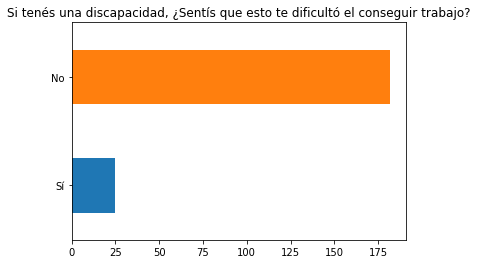

In [39]:
df[~df['¿Tenés algún tipo de discapacidad?'].isna()]['¿Sentís que esto te dificultó el conseguir trabajo?'].value_counts(sort=True, ascending=True).tail(20).plot.barh(title='Si tenés una discapacidad, ¿Sentís que esto te dificultó el conseguir trabajo?');

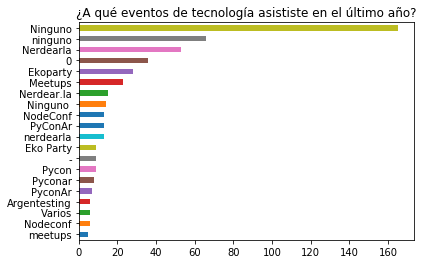

In [40]:
df['¿A qué eventos de tecnología asististe en el último año?'].value_counts(sort=True, ascending=True).tail(20).plot.barh(title='¿A qué eventos de tecnología asististe en el último año?');

'reduced in 0.030603'

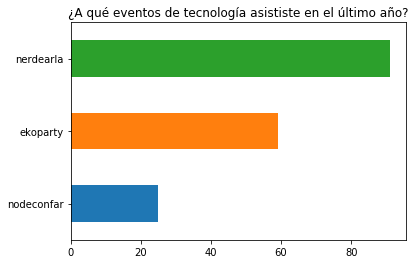

In [41]:
df = normalize_dataframe_column(df, '¿A qué eventos de tecnología asististe en el último año?', {
    '^nerdear\.?la$': 'nerdearla',
    '^eko ?partys?$': 'ekoparty',
    '^pycon(?:ar)?$': 'pyconar',
    '^nodeconf(?:ar)?$': 'nodeconfar',
})

df['¿A qué eventos de tecnología asististe en el último año?'] = df['¿A qué eventos de tecnología asististe en el último año?'].apply(lambda val: val if val in (None, 'nerdearla', 'ekoparty', 'nodeconfar',) or not isinstance(val, str) else None)
df['¿A qué eventos de tecnología asististe en el último año?'].value_counts(sort=True, ascending=True).tail(20).plot.barh(title='¿A qué eventos de tecnología asististe en el último año?');

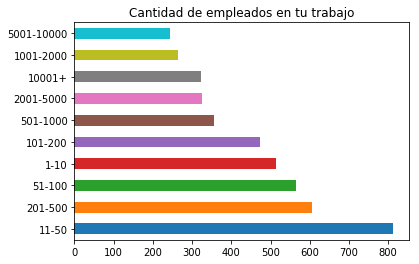

In [42]:
df['Cantidad de empleados'].value_counts().plot.barh(title='Cantidad de empleados en tu trabajo');

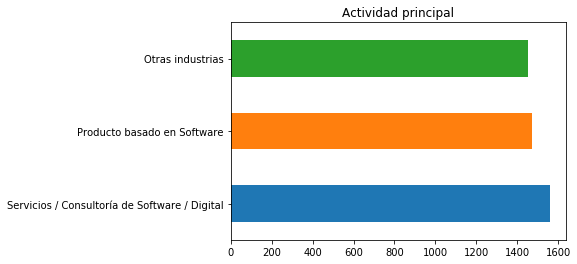

In [43]:
df['Actividad principal'].value_counts().plot.barh(title='Actividad principal');

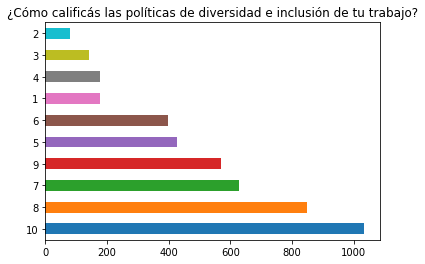

In [44]:
df['¿Cómo calificás las políticas de diversidad e inclusión?'].value_counts().plot.barh(title='¿Cómo calificás las políticas de diversidad e inclusión de tu trabajo?');

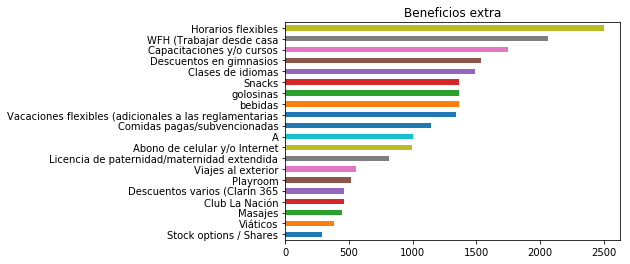

In [45]:
all_benefits = ','.join(df['Beneficios extra'].tolist())
benefits = set(x for x in [item.strip('.,-)()').strip() for s in df['Beneficios extra'].tolist() for item in s.split(',')] if x not in ('', 'a', 'no', 'nada', 'Ninguna', 'etc', 'Ninguna de las anteriores'))
pd.Series({b: all_benefits.count(b) for b in benefits}).sort_values(ascending=True).tail(20).plot.barh(title='Beneficios extra');

In [46]:
df = df[df['Años de experiencia'] < 40]
df = df[df['Tengo'] < 80]
df = df[df['Años en la empresa actual'] < 40]
df = df[(df['Salario mensual BRUTO (en tu moneda local)'] >= 10000) & (df['Salario mensual BRUTO (en tu moneda local)'] <= 300000)]

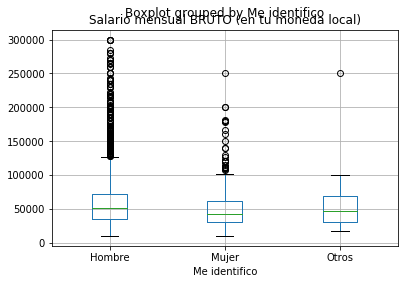

In [47]:
df.boxplot('Salario mensual BRUTO (en tu moneda local)', 'Me identifico');

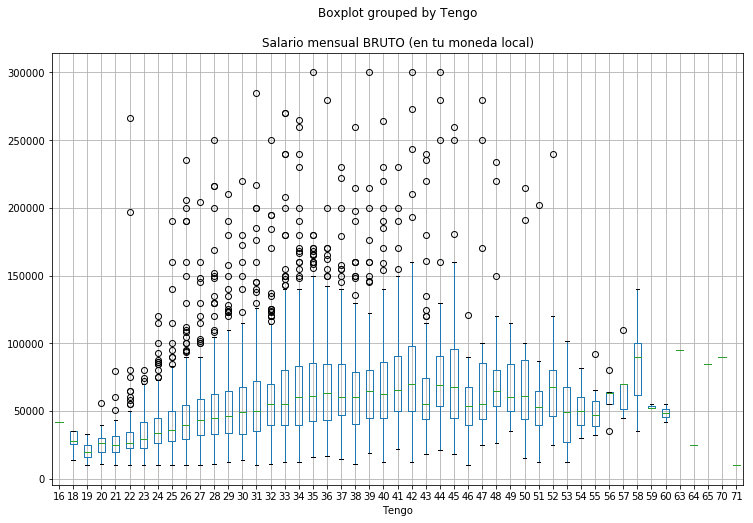

In [48]:
df.boxplot('Salario mensual BRUTO (en tu moneda local)', 'Tengo', figsize=(12, 8));

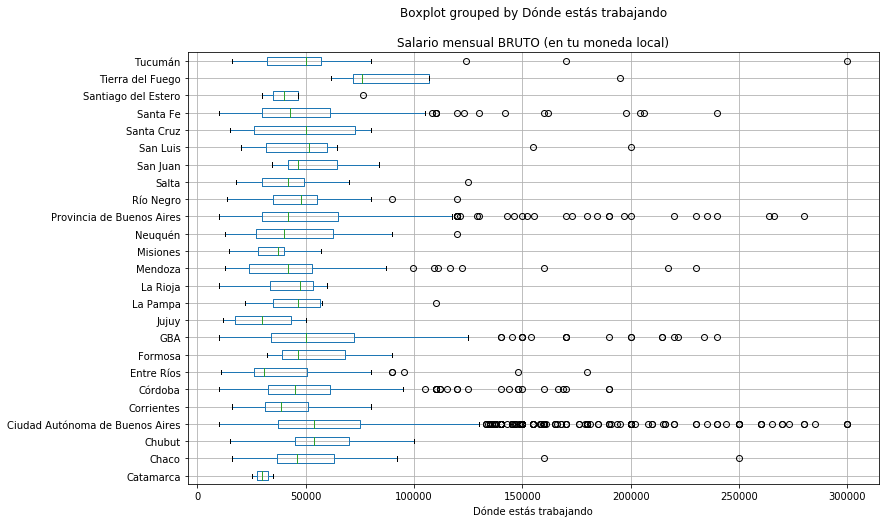

In [49]:
df.boxplot('Salario mensual BRUTO (en tu moneda local)', 'Dónde estás trabajando', figsize=(12, 8), vert=False);

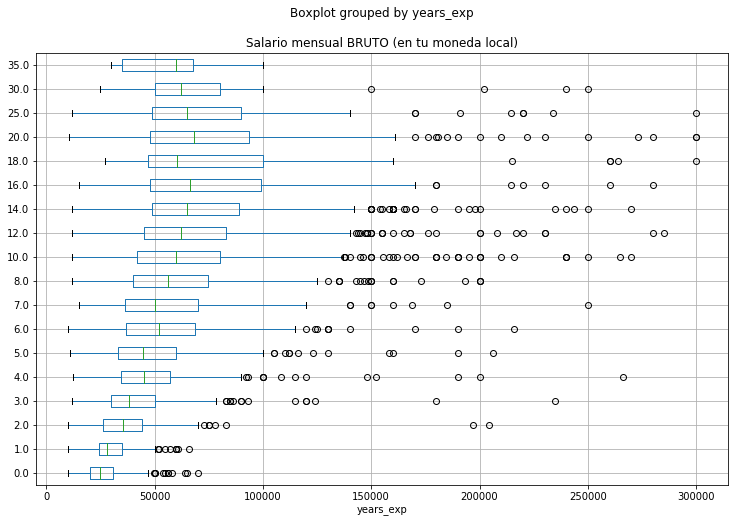

In [50]:
def years_exp(y):
    if y < 8: return int(y)
    if y < 20: return 2 * (y // 2) # 6->6, 7->6, 8->8, 9->8
    return (y // 5) * 5
    
df['years_exp'] = df['Años de experiencia'].apply(years_exp)# .value_counts(sort=True, ascending=True).tail(20).plot.barh();
df.boxplot('Salario mensual BRUTO (en tu moneda local)', 'years_exp', figsize=(12, 8), vert=False);

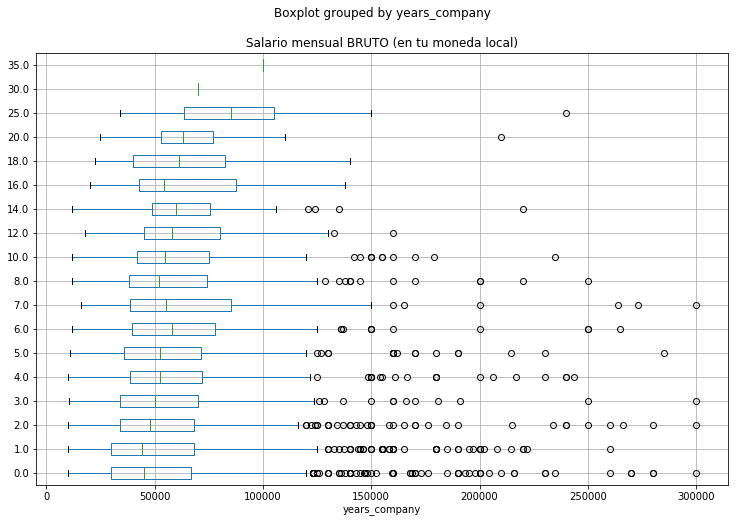

In [51]:
df['years_company'] = df['Años en la empresa actual'].apply(years_exp)
df.boxplot('Salario mensual BRUTO (en tu moneda local)', 'years_company', figsize=(12, 8), vert=False);

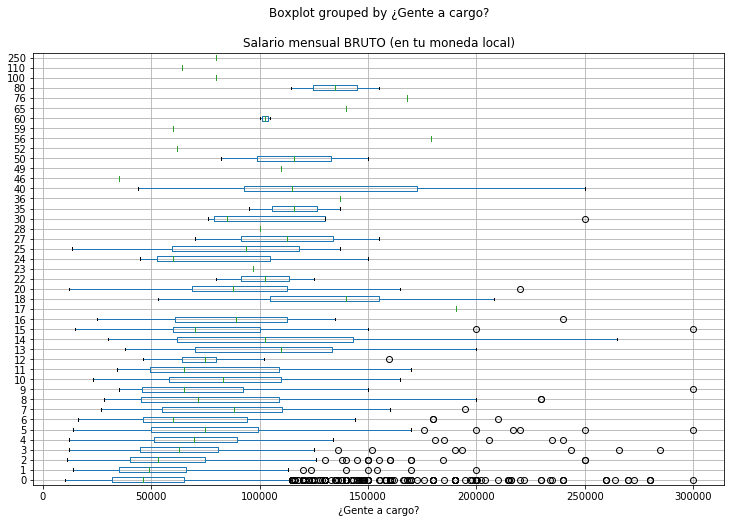

In [52]:
df.boxplot('Salario mensual BRUTO (en tu moneda local)', '¿Gente a cargo?', figsize=(12, 8), vert=False);

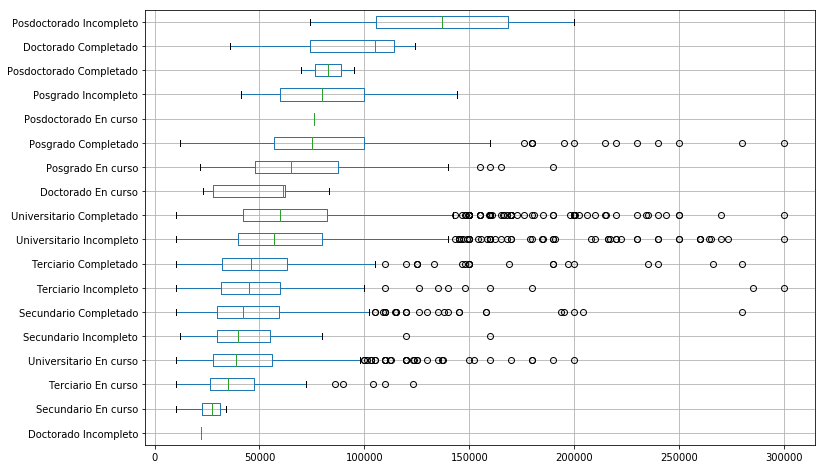

In [53]:
def boxplot_sorted(df, by, column):
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    meds = df2.median().sort_values()
    df2[meds.index].boxplot(figsize=(12, 8), vert=False)

df['studied'] = df.apply(lambda row: '{} {}'.format(row['Nivel de estudios alcanzado'], row['Estado']), axis=1)

boxplot_sorted(df, by=["studied"], column="Salario mensual BRUTO (en tu moneda local)")

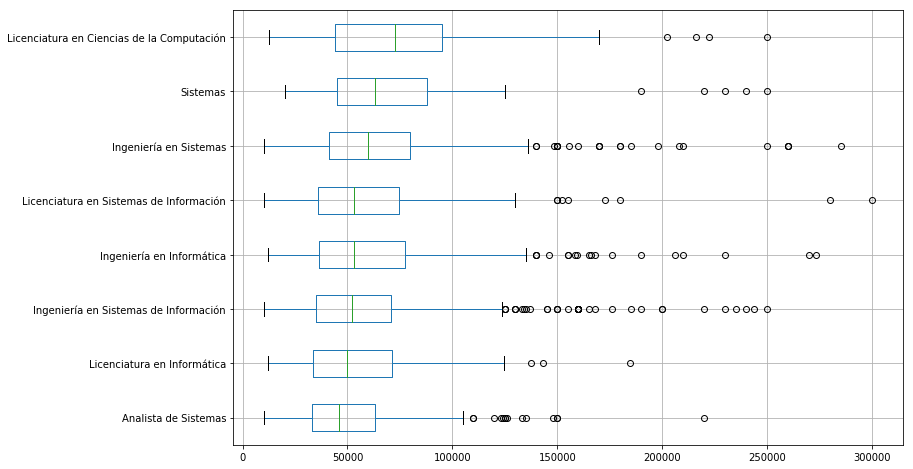

In [54]:
df['Carrera'].value_counts(sort=True, ascending=True).tail(20)#.plot.barh();
valid_carrera = 'Sistemas','Licenciatura en Informática','Licenciatura en Sistemas de Información','Licenciatura en Ciencias de la Computación','Ingeniería en Sistemas','Analista de Sistemas','Ingeniería en Informática','Ingeniería en Sistemas de Información'
boxplot_sorted(df[df['Carrera'].apply(lambda c: c in valid_carrera)], by=["Carrera"], column="Salario mensual BRUTO (en tu moneda local)")

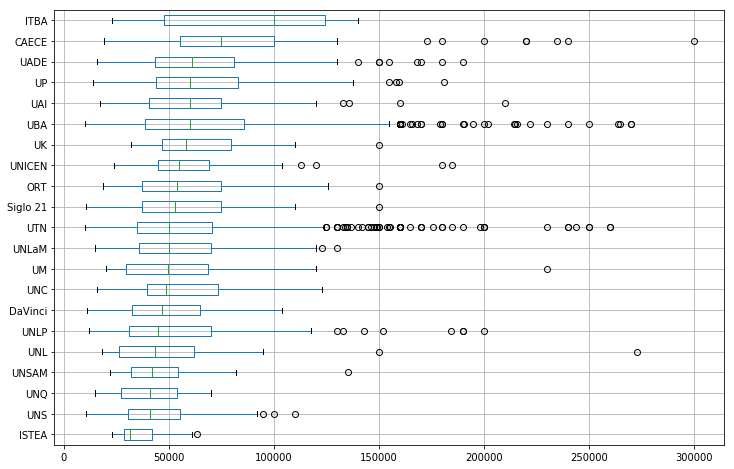

In [55]:
vc = df['Universidad'].value_counts()
univs = vc[vc > 20].index.tolist()
boxplot_sorted(df[df['Universidad'].apply(lambda c: c in univs)], by=["Universidad"], column="Salario mensual BRUTO (en tu moneda local)")

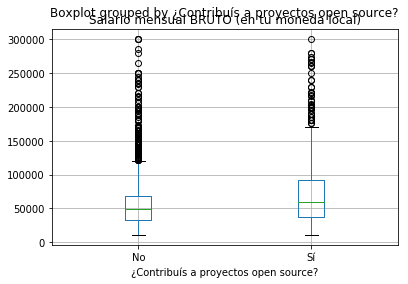

In [56]:
df.boxplot('Salario mensual BRUTO (en tu moneda local)', '¿Contribuís a proyectos open source?');

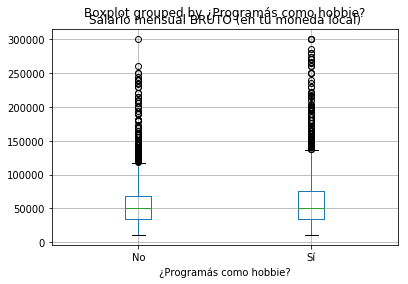

In [57]:
df.boxplot('Salario mensual BRUTO (en tu moneda local)', '¿Programás como hobbie?');

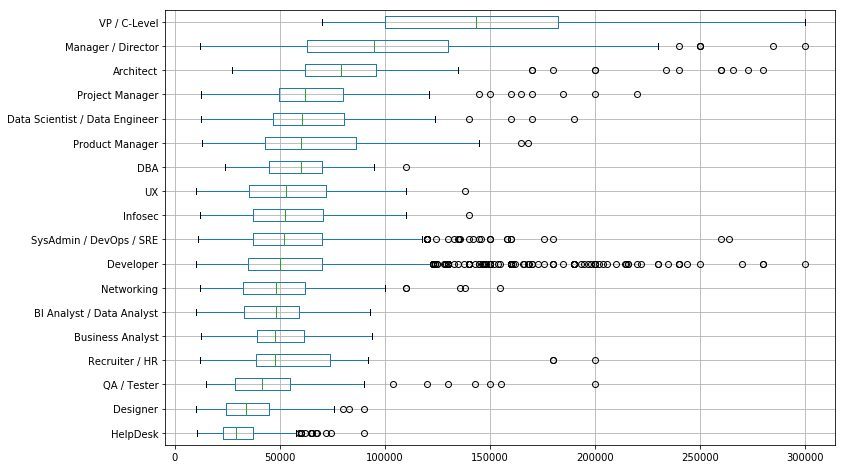

In [58]:
vc = df['Trabajo de'].value_counts()
univs = vc[vc > 20].index.tolist()
boxplot_sorted(df[df['Trabajo de'].apply(lambda c: c in univs)], by=["Trabajo de"], column="Salario mensual BRUTO (en tu moneda local)")

In [59]:
tech_counts = pd.Series(tech_count).sort_values(ascending=True)
tech_counts = tech_counts[tech_counts > 20]
tech_counts

SAP                                   28
HP-UX                                 73
*BSD                                  95
Mainframe                             97
IBM Cloud / Watson                   108
Solaris                              116
AIX                                  129
Heroku                               131
OpenStack                            136
Serverless                           193
Firebase                             213
Kubernetes                           375
Google Cloud Platform/App Engine     398
Azure                                510
VMWare                               806
Amazon Web Services                 1068
Docker                              1100
Windows Server                      1557
Linux                               2147
dtype: int64

Varias preguntas daban la posibilidad de seleccionar más de una respuesta, en ese caso vamos a abrir cada uno de estso checkboxes a una columna propia. Por ejemplo hay gente que en su trabajo usa Linux, Windows y Docker, esas personas tendrán una columna para cada una de estas plataformas.

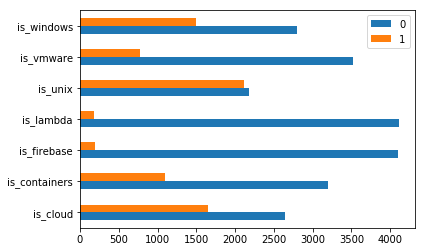

In [60]:
d = {}
for key, tech in {
        'unix': ('Linux', '*BSD', 'AIX', 'OpenStack', 'Solaris', 'HP-UX'),
        'windows': ('Windows', 'Windows Server'),
        'vmware': ('VMWare',),
        'containers': ('Docker', 'Kubernetes'),
        'cloud': ('Azure', 'Amazon Web Services', 'Google Cloud Platform/App Engine', 'OpenStack', 'Heroku', 'IBM Cloud / Watson',),
        'firebase': ('Firebase',),
        'lambda': ('Serverless',),
    }.items():
    d['is_{}'.format(key)] = df['Plataformas'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
    df['is_{}'.format(key)] = df['Plataformas'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
pd.DataFrame({x: v.value_counts() for x, v in d.items()}).T.plot.barh();

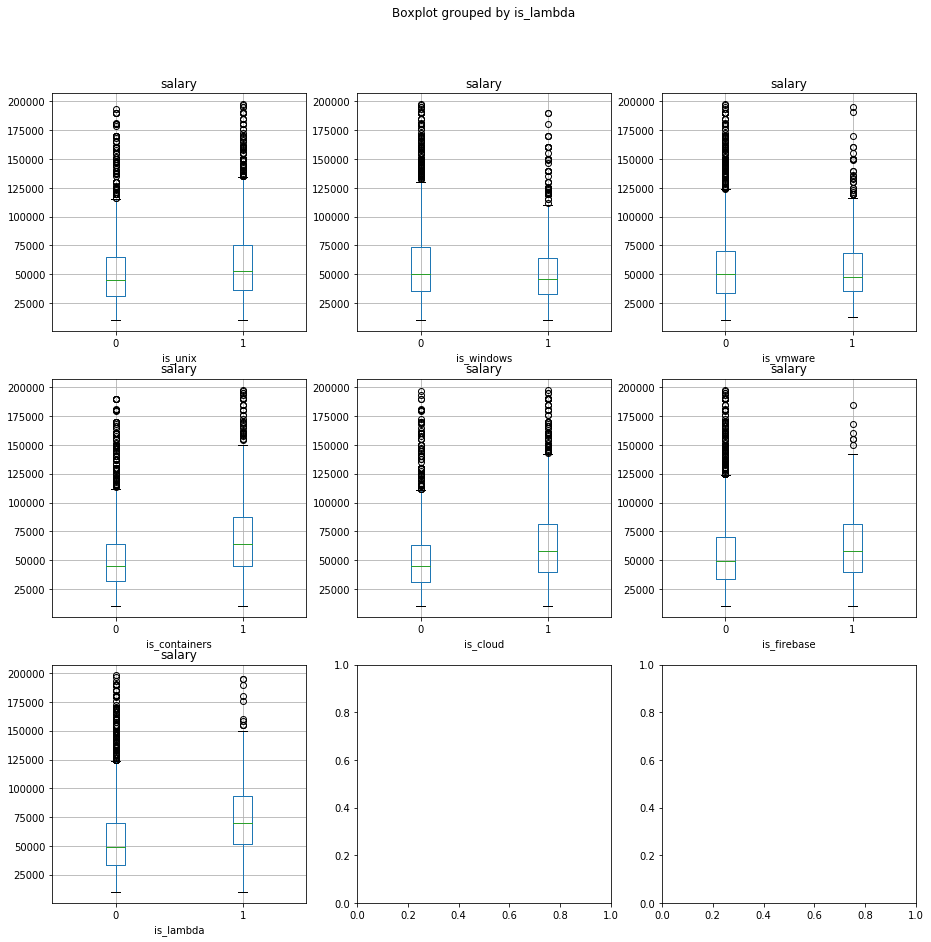

In [61]:
import matplotlib.pyplot as plt
_, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, _, _)) = plt.subplots(3, 3, figsize=(15, 15))
df['salary'] = df['Salario mensual BRUTO (en tu moneda local)']
df_low = df[df['Salario mensual BRUTO (en tu moneda local)'] < 200000]
df_low.boxplot('salary', 'is_unix', ax=ax1);
df_low.boxplot('salary', 'is_windows', ax=ax2);
df_low.boxplot('salary', 'is_vmware', ax=ax3);
df_low.boxplot('salary', 'is_containers', ax=ax4);
df_low.boxplot('salary', 'is_cloud', ax=ax5);
df_low.boxplot('salary', 'is_firebase', ax=ax6);
df_low.boxplot('salary', 'is_lambda', ax=ax7);

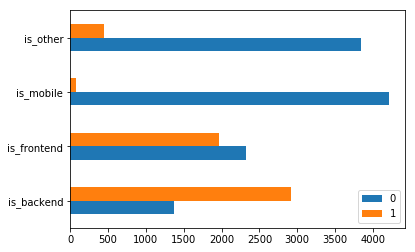

In [62]:
d = {}
for key, tech in {
        'frontend': ('Javascript', 'HTML', 'CSS', 'jQuery'),
        'backend': ('Java', 'PHP', 'Python', '.NET', 'NodeJS', 'C#', 'Ruby', 'Perl', 'Go', 'Scala'),
        'other': ('VB*', 'C++', 'C,', 'ABAP'),
        'mobile': ('Swift', 'Objective-C')
    }.items():
    d['is_{}'.format(key)] = df['Lenguajes de programación'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
    df['is_{}'.format(key)] = df['Lenguajes de programación'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
pd.DataFrame({x: v.value_counts() for x, v in d.items()}).T.plot.barh();

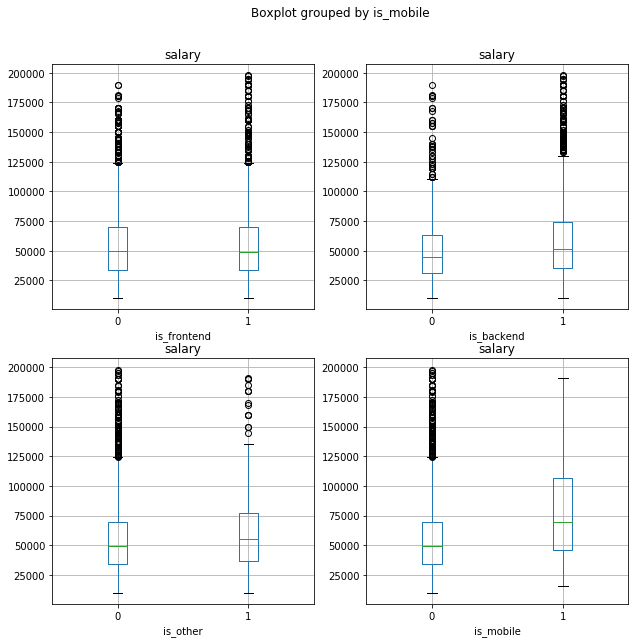

In [63]:
import matplotlib.pyplot as plt
_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
df_low = df[df['Salario mensual BRUTO (en tu moneda local)'] < 200000]
df_low.boxplot('salary', 'is_frontend', ax=ax1);
df_low.boxplot('salary', 'is_backend', ax=ax2);
df_low.boxplot('salary', 'is_other', ax=ax3);
df_low.boxplot('salary', 'is_mobile', ax=ax4);

In [64]:
fw_counts = pd.Series(fw_count).sort_values(ascending=True)
fw_counts = fw_counts[fw_counts > 20]
fw_counts

Rails          22
Vue.js         23
Torch          24
Laravel        39
TensorFlow     81
Hadoop         85
Drupal         99
Spark         109
Cordova       142
Django        251
WordPress     365
Spring        447
.NET Core     520
React.js      620
Angular       689
Node.js       925
dtype: int64

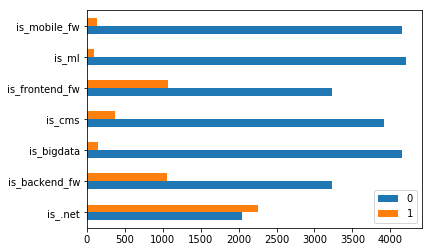

In [65]:
d = {}
for key, tech in {
        'frontend_fw': ('Angular', 'React.js', 'Vue.js'),
        'backend_fw': ('Node.js', 'Django', 'Laravel'),
        'mobile_fw': ('Cordova',),
        '.net': ('.NET Core'),
        'cms': ('WordPress', 'Drupal'),
        'bigdata': ('Spark', 'Hadoop'),
        'ml': ('TensorFlow', 'Torch',),
    }.items():
    d['is_{}'.format(key)] = df['Frameworks, herramientas y librerías'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
    df['is_{}'.format(key)] = df['Frameworks, herramientas y librerías'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
pd.DataFrame({x: v.value_counts() for x, v in d.items()}).T.plot.barh();

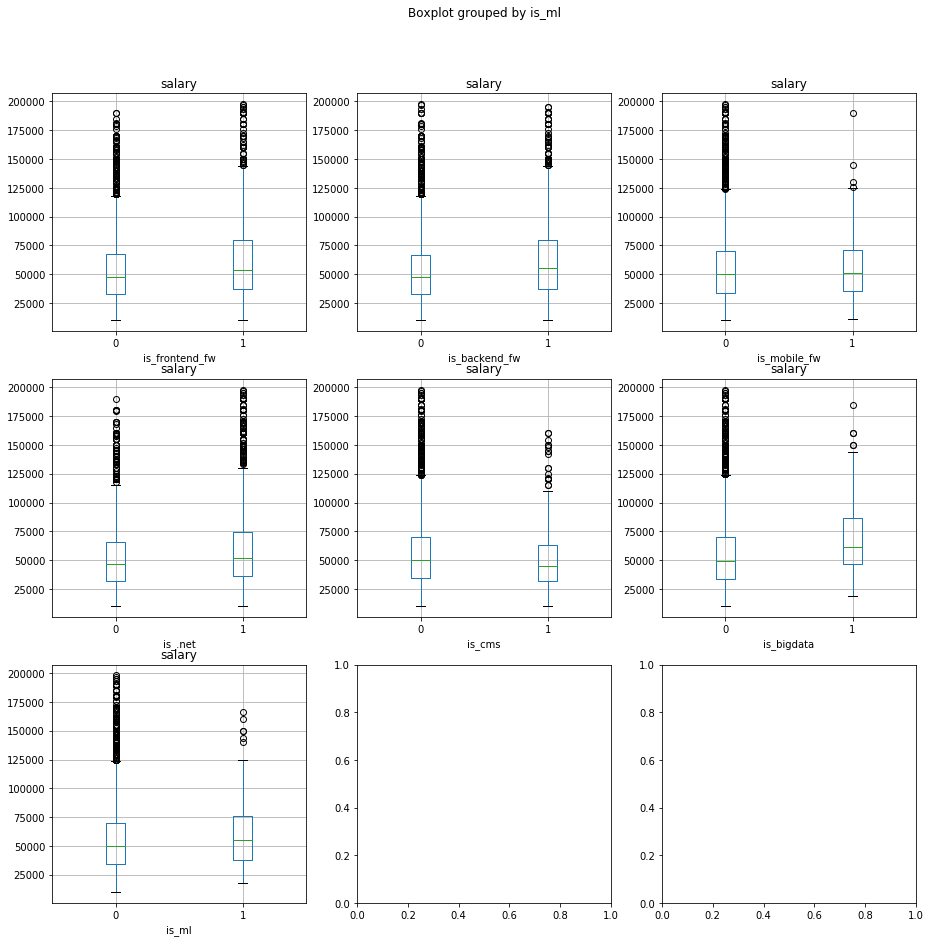

In [66]:
import matplotlib.pyplot as plt
_, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, _, _)) = plt.subplots(3, 3, figsize=(15, 15))
df_low = df[df['Salario mensual BRUTO (en tu moneda local)'] < 200000]
df_low.boxplot('salary', 'is_frontend_fw', ax=ax1);
df_low.boxplot('salary', 'is_backend_fw', ax=ax2);
df_low.boxplot('salary', 'is_mobile_fw', ax=ax3);
df_low.boxplot('salary', 'is_.net', ax=ax4);
df_low.boxplot('salary', 'is_cms', ax=ax5);
df_low.boxplot('salary', 'is_bigdata', ax=ax6);
df_low.boxplot('salary', 'is_ml', ax=ax7);

In [67]:
db_counts = pd.Series(db_count).sort_values(ascending=True)
db_counts = db_counts[db_counts > 20]
db_counts

Teradata                     22
Percona Server               22
ProxySQL                     23
Neo4j                        34
Apache HBase                 58
Informix                     62
Apache Hive                  80
Amazon Redshift              92
Google Cloud Storage        121
IBM Db2                     133
Cassandra                   172
Amazon RDS/Aurora           191
Amazon DynamoDB             204
CosmosDB                    239
etc)                        239
Microsoft Azure (Tables     239
SQL                         239
Redis                       376
SQLite                      389
ElasticSearch               389
MariaDB                     571
MongoDB                     661
Oracle                      671
PostgreSQL                  886
MSSQL                      1191
MySQL                      1703
dtype: int64

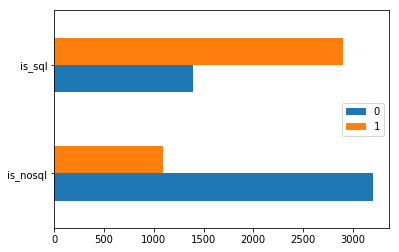

In [68]:
d = {}
for key, tech in {
        'sql': ('MySQL', 'MSSQL', 'PostgreSQL', 'Oracle', 'MariaDB', 'Microsoft Azure', 'IBM Db2'),
        'nosql': ('MongoDB', 'ElasticSearch', 'Redis', 'Amazon DynamoDB', 'Cassandra', 'Google Cloud Storage'),
    }.items():
    d['is_{}'.format(key)] = df['Bases de datos'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
    df['is_{}'.format(key)] = df['Bases de datos'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
pd.DataFrame({x: v.value_counts() for x, v in d.items()}).T.plot.barh();

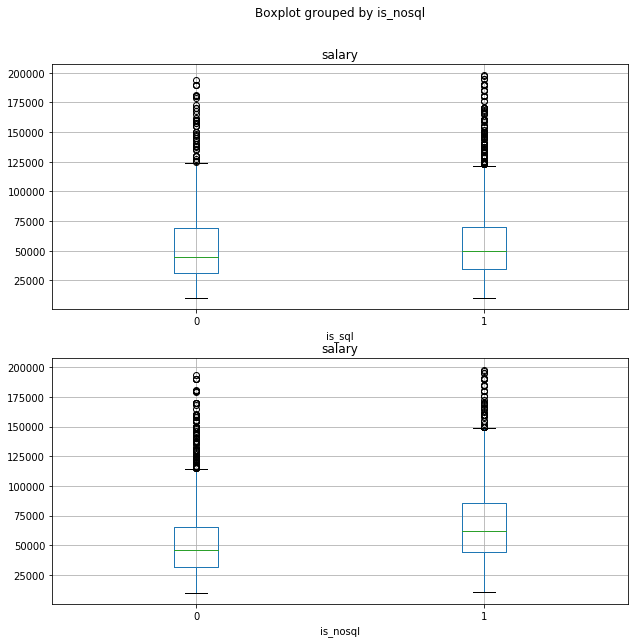

In [69]:
import matplotlib.pyplot as plt
_, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(10, 10))
df_low = df[df['Salario mensual BRUTO (en tu moneda local)'] < 200000]
df_low.boxplot('salary', 'is_sql', ax=ax1);
df_low.boxplot('salary', 'is_nosql', ax=ax2);

In [70]:
qat_counts = pd.Series(qat_count).sort_values(ascending=True)
qat_counts = qat_counts[qat_counts > 20]
qat_counts

HP LoadRunner              35
OpenQA                     36
Test Complete              49
RSpec                      58
Visual Studio Coded UI    128
Selenium                  418
dtype: int64

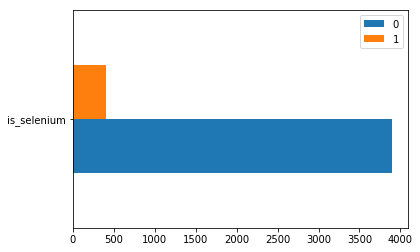

In [71]:
d = {}
for key, tech in {
        'selenium': ('Selenium',),
    }.items():
    d['is_{}'.format(key)] = df['QA / Testing'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
    df['is_{}'.format(key)] = df['QA / Testing'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
pd.DataFrame({x: v.value_counts() for x, v in d.items()}).T.plot.barh();

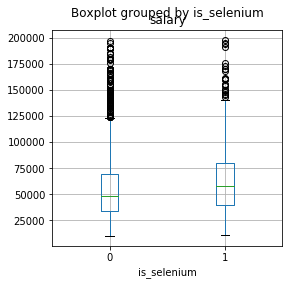

In [72]:
import matplotlib.pyplot as plt
_, ((ax1)) = plt.subplots(1, 1, figsize=(4, 4))
df_low = df[df['Salario mensual BRUTO (en tu moneda local)'] < 200000]
df_low.boxplot('salary', 'is_selenium', ax=ax1);

In [73]:
ide_counts = pd.Series(ide_count).sort_values(ascending=True)
ide_counts = ide_counts[ide_counts > 200]
ide_counts

NetBeans           209
PyCharm            212
Vi                 347
Atom               373
Android Studio     381
Eclipse            606
IntelliJ           618
Vim                625
Notepad++          783
Sublime Text       861
Visual Studio     1308
dtype: int64

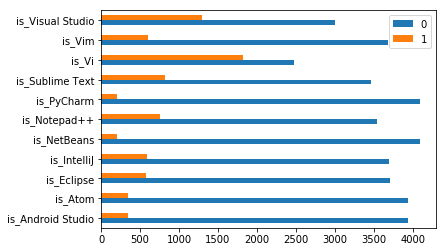

In [74]:
d = {}
for ide in ide_counts.index.tolist():
    key, tech = ide, (ide,)
    d['is_{}'.format(key)] = df['IDEs'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
    df['is_{}'.format(key)] = df['IDEs'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
pd.DataFrame({x: v.value_counts() for x, v in d.items()}).T.plot.barh();

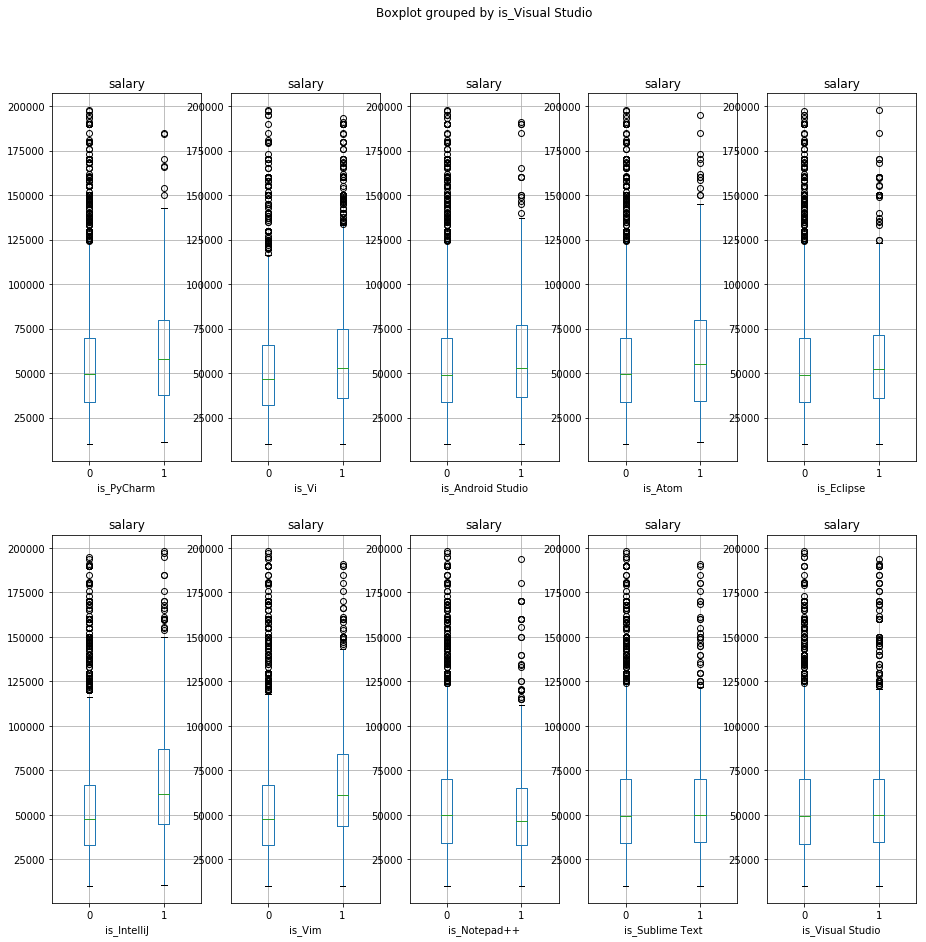

In [75]:
import matplotlib.pyplot as plt
_, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5, figsize=(15, 15))
df_low = df[df['Salario mensual BRUTO (en tu moneda local)'] < 200000]

df_low.boxplot('salary', 'is_PyCharm', ax=ax1);
df_low.boxplot('salary', 'is_Vi', ax=ax2);
df_low.boxplot('salary', 'is_Android Studio', ax=ax3);
df_low.boxplot('salary', 'is_Atom', ax=ax4);
df_low.boxplot('salary', 'is_Eclipse', ax=ax5);
df_low.boxplot('salary', 'is_IntelliJ', ax=ax6);
df_low.boxplot('salary', 'is_Vim', ax=ax7);
df_low.boxplot('salary', 'is_Notepad++', ax=ax8);
df_low.boxplot('salary', 'is_Sublime Text', ax=ax9);
df_low.boxplot('salary', 'is_Visual Studio', ax=ax10);

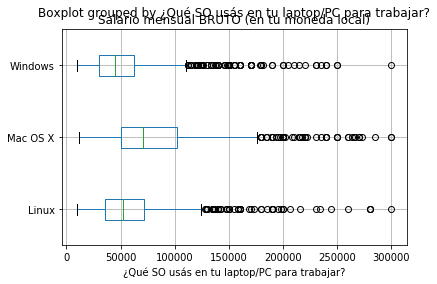

In [76]:
df.boxplot('Salario mensual BRUTO (en tu moneda local)', '¿Qué SO usás en tu laptop/PC para trabajar?', vert=False);

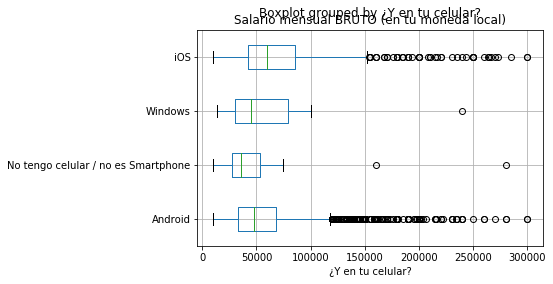

In [77]:
df.boxplot('Salario mensual BRUTO (en tu moneda local)', '¿Y en tu celular?', vert=False);

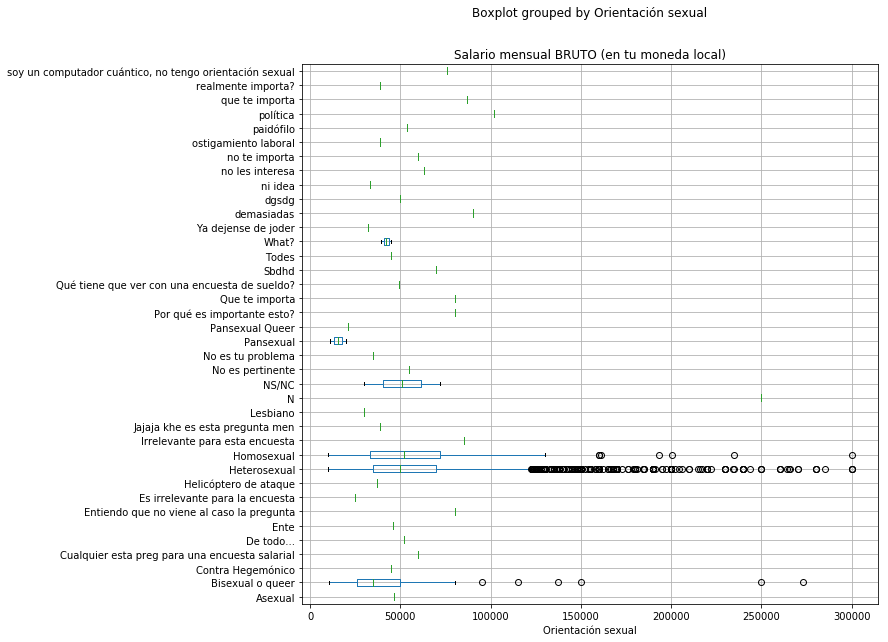

In [78]:
df.boxplot('Salario mensual BRUTO (en tu moneda local)', 'Orientación sexual', vert=False, figsize=(10, 10));

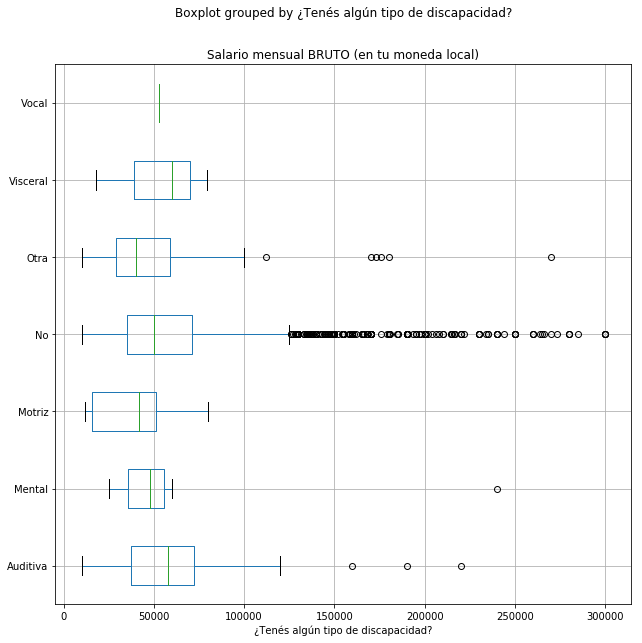

In [79]:
df_copy = df
df_copy['¿Tenés algún tipo de discapacidad?'] = df_copy['¿Tenés algún tipo de discapacidad?'].fillna('No')
df_copy.boxplot('Salario mensual BRUTO (en tu moneda local)', '¿Tenés algún tipo de discapacidad?', vert=False, figsize=(10, 10));

Ahora veamos de hacer un modelo de predicción lineal. Primero veamos cómo funciona predecir con pocas columnas el sueldo contra el logaritmo del sueldo. Como esta tiende a estar desbalanceado hacia valores extremos podemos aplicarle un logaritmo para que quede más parecida a una normal.

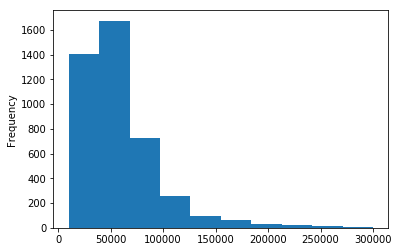

In [80]:
df[(df['Salario mensual BRUTO (en tu moneda local)'] >= 10000) & (df['Salario mensual BRUTO (en tu moneda local)'] <= 300000)]['Salario mensual BRUTO (en tu moneda local)'].plot.hist();


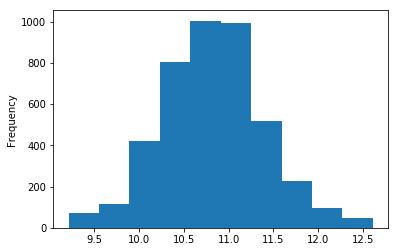

In [81]:
import numpy as np
np.log(df[(df['Salario mensual BRUTO (en tu moneda local)'] >= 10000) & (df['Salario mensual BRUTO (en tu moneda local)'] <= 300000)]['Salario mensual BRUTO (en tu moneda local)']).plot.hist();

## Regresión Lineal
Probemos con unas pocas columnas cómo se desempeña un modelo sencillo contra ambas.

El primer tipo de modelo que vamos a hacer es regresión lineal, que básicamente multiplica cada valor de cada columnas por un número fijo (que la computadora determina al entrenar) y después los suma.

Para eso tenemos que pasar todas las columnas a valores numéricos. Vamos a aplicar _one hot encoder_ para que el género sea 0 si es hombre, 1 si es mujer, 2 para los demás.

In [82]:
df1 = df[['Me identifico', 'Tengo', 'Años de experiencia', 'Salario mensual BRUTO (en tu moneda local)']]
df1.head()

,Me identifico,Tengo,Años de experiencia,Salario mensual BRUTO (en tu moneda local)
0,Hombre,22,2.0,35000.0
1,Hombre,23,2.0,25000.0
2,Mujer,35,8.0,50000.0
3,Hombre,41,20.0,70000.0
4,Hombre,35,5.0,35000.0


In [83]:
df1['Me identifico'] = df['Me identifico'].apply(lambda x: {
    'Hombre': 0,
    'Mujer': 1,
    'Otros': 2,
}[x])
df1.head()

/home/sebastianwaisbrot/.local/share/virtualenvs/sysarmy-sueldos-b5vDcW_P/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Me identifico,Tengo,Años de experiencia,Salario mensual BRUTO (en tu moneda local)
0,0,22,2.0,35000.0
1,0,23,2.0,25000.0
2,1,35,8.0,50000.0
3,0,41,20.0,70000.0
4,0,35,5.0,35000.0


In [84]:
from sklearn.linear_model import LinearRegression

X, y = df1[['Me identifico', 'Tengo', 'Años de experiencia']], df['Salario mensual BRUTO (en tu moneda local)']
reg = LinearRegression().fit(X, y)
reg.score(X, y) # r2

0.14023841085242794

In [85]:
from sklearn.linear_model import LinearRegression

X, y = df1[['Me identifico', 'Tengo', 'Años de experiencia']], np.log(df['Salario mensual BRUTO (en tu moneda local)'])
reg = LinearRegression().fit(X, y)
reg.score(X, y) # r2

0.18960833972183533

El score (r^2) es un número no mayor a 1 que representa qué parte del sueldo se puede explicar con las variables dadas. Vemos que es mayor cuando intentamos ver el logaritmo del salario en vez de su valor en pesos.

Veamos de usar para representar el género números correlativos usar el promedio del valor del sueldo.

In [86]:
df2 = df[['Me identifico', 'Tengo', 'Años de experiencia', 'Salario mensual BRUTO (en tu moneda local)']]
df2['logsalary'] = np.log(df2['Salario mensual BRUTO (en tu moneda local)'])
df2 = df2.drop('Salario mensual BRUTO (en tu moneda local)', axis=1)
gender_map = df2[['Me identifico', 'logsalary']].groupby('Me identifico').mean().to_dict()['logsalary']
df2['Me identifico'] = df2['Me identifico'].apply(lambda x: gender_map[x])
df2

/home/sebastianwaisbrot/.local/share/virtualenvs/sysarmy-sueldos-b5vDcW_P/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Me identifico,Tengo,Años de experiencia,logsalary
0,10.840954,22,2.0,10.463103
1,10.840954,23,2.0,10.126631
2,10.670173,35,8.0,10.819778
3,10.840954,41,20.0,11.156251
4,10.840954,35,5.0,10.463103
5,10.840954,38,16.0,10.757903
7,10.840954,32,10.0,10.736397
8,10.840954,28,7.0,12.429216
9,10.840954,29,0.0,9.740969
11,10.840954,27,8.0,11.982929


In [87]:
X, y = df2[['Me identifico', 'Tengo', 'Años de experiencia']], df2['logsalary']
reg = LinearRegression().fit(X, y)
reg.score(X, y) # r2

0.19008627575830495

El score mejora pero poco. Veamos de aplicarlo a las otras columnas también.

In [88]:
df3 = df[['Me identifico', 'Tengo', 'Años de experiencia', 'Salario mensual BRUTO (en tu moneda local)']]
df3['logsalary'] = np.log(df3['Salario mensual BRUTO (en tu moneda local)'])
df3 = df3.drop('Salario mensual BRUTO (en tu moneda local)', axis=1)
gender_map = df3[['Me identifico', 'logsalary']].groupby('Me identifico').mean().to_dict()['logsalary']
age_map = df3[['Tengo', 'logsalary']].groupby('Tengo').mean().to_dict()['logsalary']
df3['Me identifico'] = df3['Me identifico'].apply(lambda x: gender_map[x])
df3['Tengo'] = df3['Tengo'].apply(lambda x: age_map[x])
df3

/home/sebastianwaisbrot/.local/share/virtualenvs/sysarmy-sueldos-b5vDcW_P/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Me identifico,Tengo,Años de experiencia,logsalary
0,10.840954,10.250469,2.0,10.463103
1,10.840954,10.310936,2.0,10.126631
2,10.670173,11.028619,8.0,10.819778
3,10.840954,11.100770,20.0,11.156251
4,10.840954,11.028619,5.0,10.463103
5,10.840954,10.989701,16.0,10.757903
7,10.840954,10.897024,10.0,10.736397
8,10.840954,10.744458,7.0,12.429216
9,10.840954,10.770821,0.0,9.740969
11,10.840954,10.685548,8.0,11.982929


In [89]:
X, y = df3[['Me identifico', 'Tengo', 'Años de experiencia']], df3['logsalary']
reg = LinearRegression().fit(X, y)
reg.score(X, y) # r2

0.2364607301857835

In [90]:
import numpy as np
df4 = df[['Me identifico', 'Tengo', 'Años de experiencia', 'Salario mensual BRUTO (en tu moneda local)']]
df4['logsalary'] = np.log(df4['Salario mensual BRUTO (en tu moneda local)'])
df4 = df4.drop('Salario mensual BRUTO (en tu moneda local)', axis=1)
gender_map = df4[['Me identifico', 'logsalary']].groupby('Me identifico').mean().to_dict()['logsalary']
age_map = df4[['Tengo', 'logsalary']].groupby('Tengo').mean().to_dict()['logsalary']
exp_map = df4[['Años de experiencia', 'logsalary']].groupby('Años de experiencia').mean().to_dict()['logsalary']
df4['Me identifico'] = df4['Me identifico'].apply(lambda x: gender_map[x])
df4['Tengo'] = df4['Tengo'].apply(lambda x: age_map[x])
df4['Años de experiencia'] = df4['Años de experiencia'].apply(lambda x: exp_map[x])
df4

/home/sebastianwaisbrot/.local/share/virtualenvs/sysarmy-sueldos-b5vDcW_P/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Me identifico,Tengo,Años de experiencia,logsalary
0,10.840954,10.250469,10.431556,10.463103
1,10.840954,10.310936,10.431556,10.126631
2,10.670173,11.028619,10.913306,10.819778
3,10.840954,11.100770,11.113930,11.156251
4,10.840954,11.028619,10.709494,10.463103
5,10.840954,10.989701,11.151518,10.757903
7,10.840954,10.897024,10.949158,10.736397
8,10.840954,10.744458,10.853070,12.429216
9,10.840954,10.770821,10.106575,9.740969
11,10.840954,10.685548,10.913306,11.982929


In [91]:
X, y = df4[['Me identifico', 'Tengo', 'Años de experiencia']], df4['logsalary']
reg = LinearRegression().fit(X, y)
reg.score(X, y) # r2

0.28882472097730805

La mejora ya empieza a ser más significativa.

Sin embargo estamos evaluando al modelo con los datos de entrenamiento. En vez de eso vamos a aplicar _cross validation_ que separa del conjunto de datos un grupo que no se va a usar para entrenar y se usar sólo para testear. Una vez calculado el score, se devuelve este grupo y se saca otro.

In [92]:
df4.shape

(4293, 4)

In [93]:
df4.shape[0] // 5

858

In [94]:
from sklearn.model_selection import cross_val_score
lr = LinearRegression()
cross_val_score(lr, X, y, cv=5).mean()

0.2620397412948236

Al calcular los promedios de las categorías usé información que en _cross validation_ se usó para testear. Esto se llama _leak_ y es un error. Lo que debiera usar es el promedio de la categoría sólo con los datos de test.

In [95]:
df5 = df[['Me identifico', 'Tengo', 'Años de experiencia', 'Salario mensual BRUTO (en tu moneda local)']]
df5['logsalary'] = np.log(df5['Salario mensual BRUTO (en tu moneda local)'])
df5 = df5.drop('Salario mensual BRUTO (en tu moneda local)', axis=1)
df5

/home/sebastianwaisbrot/.local/share/virtualenvs/sysarmy-sueldos-b5vDcW_P/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Me identifico,Tengo,Años de experiencia,logsalary
0,Hombre,22,2.0,10.463103
1,Hombre,23,2.0,10.126631
2,Mujer,35,8.0,10.819778
3,Hombre,41,20.0,11.156251
4,Hombre,35,5.0,10.463103
5,Hombre,38,16.0,10.757903
7,Hombre,32,10.0,10.736397
8,Hombre,28,7.0,12.429216
9,Hombre,29,0.0,9.740969
11,Hombre,27,8.0,11.982929


In [96]:
import category_encoders as ce
encoder = ce.TargetEncoder(cols=['Tengo'])
encoder.fit_transform(df5[['Tengo']], df5['logsalary'])

,Tengo
0,10.250469
1,10.310936
2,11.028619
3,11.100770
4,11.028619
5,10.989701
7,10.897024
8,10.744458
9,10.770821
11,10.685548


In [97]:
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.TargetEncoder(cols=['Me identifico', 'Tengo', 'Años de experiencia']),
    LinearRegression(),
)

cross_val_score(pipeline, X, y, cv=5).mean()

0.2429957505664678

Probemos ahora incluir más columnas y veamos cómo cambiar el r2.

In [98]:
df.columns

Index(['Me identifico', 'Tengo', 'Dónde estás trabajando',
       'Años de experiencia', 'Años en la empresa actual',
       'Años en el puesto actual', '¿Gente a cargo?',
       'Nivel de estudios alcanzado', 'Estado', 'Carrera', 'Universidad',
       'Realizaste cursos de especialización',
       '¿Contribuís a proyectos open source?', '¿Programás como hobbie?',
       'Trabajo de', 'Plataformas', 'Lenguajes de programación',
       'Frameworks, herramientas y librerías', 'Bases de datos',
       'QA / Testing', 'IDEs', '¿Qué SO usás en tu laptop/PC para trabajar?',
       '¿Y en tu celular?', '¿Tenés guardias?', 'Cuánto cobrás por guardia',
       '¿Porcentaje, bruto o neto?', 'Tipo de contrato',
       'Salario mensual BRUTO (en tu moneda local)',
       'Salario mensual NETO (en tu moneda local)',
       '¿Qué tan conforme estás con tu sueldo?',
       'Cómo creés que está tu sueldo con respecto al último semestre',
       'Recibís algún tipo de bono', 'A qué está atado el bono',


In [99]:
from sklearn.pipeline import make_pipeline

cols = [
    'Me identifico',
    'Tengo',
    'Dónde estás trabajando',
    '¿Gente a cargo?',
    'Carrera',
    'Universidad',
    'Realizaste cursos de especialización',
    '¿Contribuís a proyectos open source?',
    '¿Programás como hobbie?',
    'Trabajo de',
    '¿Qué SO usás en tu laptop/PC para trabajar?',
    '¿Y en tu celular?',
    'Tipo de contrato',
    '¿Sufriste o presenciaste situaciones de violencia laboral?',
    'Orientación sexual',
    '¿Tenés algún tipo de discapacidad?',
    '¿A qué eventos de tecnología asististe en el último año?',
    'Cantidad de empleados',
    'Actividad principal',
    'years_exp', 'years_company', 'studied',
   'is_windows', 'is_lambda', 'is_vmware', 'is_containers', 'is_firebase',
   'is_unix', 'is_cloud', 'is_other', 'is_backend',
   'is_frontend', 'is_mobile', 'is_bigdata', 'is_.net', 'is_ml',
   'is_mobile_fw', 'is_frontend_fw', 'is_cms', 'is_backend_fw', 'is_sql',
   'is_nosql', 'is_selenium', 'is_NetBeans', 'is_PyCharm', 'is_Vi',
   'is_Atom', 'is_Android Studio', 'is_Eclipse', 'is_IntelliJ', 'is_Vim',
   'is_Notepad++', 'is_Sublime Text', 'is_Visual Studio']
pipeline = make_pipeline(
    ce.TargetEncoder(cols=cols),
    LinearRegression(),
)

cross_val_score(pipeline, df[cols], df4['logsalary'], cv=5).mean()

0.557629915581835

Ahora podemos explicar mucho más del sueldo. También podemos ver cuál de las respuestas es más significativa sobre el salario.

PERO NO. Para poder ver eso en realidad debería normalizar los valores.

// TODO: restarle el promedio y dividir por el desvío

In [100]:
pipeline.fit(df[cols], df4['logsalary'])
dict(zip(cols, pipeline.steps[1][1].coef_.tolist()))

{'Actividad principal': 0.406584811110311,
 'Cantidad de empleados': 0.5985489955594392,
 'Carrera': 0.3603239584632961,
 'Dónde estás trabajando': 0.5535514915076669,
 'Me identifico': 0.3387120656737454,
 'Orientación sexual': 0.3128788504104432,
 'Realizaste cursos de especialización': 0.34846903928330897,
 'Tengo': 0.19880737681733918,
 'Tipo de contrato': 0.6285049999573314,
 'Trabajo de': 0.37223918070365714,
 'Universidad': 0.3144869998811176,
 'is_.net': 0.12862171286412555,
 'is_Android Studio': -0.36552512478974464,
 'is_Atom': -0.07722487571836556,
 'is_Eclipse': 0.4380560059902274,
 'is_IntelliJ': 0.21711755361884744,
 'is_NetBeans': 0.30872163937852426,
 'is_Notepad++': 0.30696027095196166,
 'is_PyCharm': 0.2374818838991234,
 'is_Sublime Text': -1.1777708585845388,
 'is_Vi': 0.18533593637180157,
 'is_Vim': 0.1421236864227835,
 'is_Visual Studio': 0.08998740763061819,
 'is_backend': 0.4819232095832461,
 'is_backend_fw': 0.03400489103787041,
 'is_bigdata': -0.088833632349221

También podemos usar el modelo para buscar respuestas que difieran mucho de lo esperado y con eso filtrarlos si los consideramos que los datos son falsos. Veamos las tres respuestas que más se separan de lo que predice el modelo.

In [101]:
df6 = df
df6['logsalary'] = df4['logsalary']
df6['predicted'] = pd.Series(pipeline.predict(df[cols]))
df6['diff'] = (df6['predicted'] - df6['logsalary']).abs()
df6.sort_values('diff', ascending=False).iloc[0].to_dict()

{'A qué está atado el bono': 'No recibo bono',
 'Actividad principal': 'Otras industrias',
 'Años de experiencia': 20.0,
 'Años en el puesto actual': 20.0,
 'Años en la empresa actual': 3.0,
 'Bases de datos': nan,
 'Beneficios extra': 'Ninguna de las anteriores',
 'Cantidad de empleados': '11-50',
 'Carrera': 'Ingeniería',
 'Cuánto cobrás por guardia': 0.0,
 'Cómo creés que está tu sueldo con respecto al último semestre': 1,
 'Dónde estás trabajando': 'Ciudad Autónoma de Buenos Aires',
 'Estado': 'Incompleto',
 'Frameworks, herramientas y librerías': nan,
 'IDEs': nan,
 'Lenguajes de programación': nan,
 'Me identifico': 'Hombre',
 'Nivel de estudios alcanzado': 'Universitario',
 'Orientación sexual': 'Heterosexual',
 'Plataformas': 'Windows Server',
 'QA / Testing': nan,
 'Realizaste cursos de especialización': 'Sí, de forma particular',
 'Recibís algún tipo de bono': 'No',
 'Salario mensual BRUTO (en tu moneda local)': 10400.0,
 'Salario mensual NETO (en tu moneda local)': 10400.0,


In [102]:
df6.sort_values('diff', ascending=False).iloc[1].to_dict()

{'A qué está atado el bono': 'Bono de Fin de Año',
 'Actividad principal': 'Producto basado en Software',
 'Años de experiencia': 4.0,
 'Años en el puesto actual': 4.0,
 'Años en la empresa actual': 2.0,
 'Bases de datos': 'Amazon DynamoDB, MongoDB',
 'Beneficios extra': 'Capacitaciones y/o cursos, Horarios flexibles, Vacaciones flexibles (adicionales a las reglamentarias), Viajes al exterior, WFH (Trabajar desde casa)',
 'Cantidad de empleados': '11-50',
 'Carrera': 'Tecnicatura Electrónica',
 'Cuánto cobrás por guardia': 0.0,
 'Cómo creés que está tu sueldo con respecto al último semestre': 3,
 'Dónde estás trabajando': 'Provincia de Buenos Aires',
 'Estado': 'Completado',
 'Frameworks, herramientas y librerías': '.NET Core, Node.js, React.js',
 'IDEs': 'Android Studio, Vi, Vim, Visual Studio, Xcode, Visual Studio Code',
 'Lenguajes de programación': '.NET, C++, C#, CSS, HTML, Java, Javascript, Objective-C, Swift',
 'Me identifico': 'Hombre',
 'Nivel de estudios alcanzado': 'Terciari

In [103]:
df6.sort_values('diff', ascending=False).iloc[2].to_dict()

{'A qué está atado el bono': 'Mix de las anteriores',
 'Actividad principal': 'Servicios / Consultoría de Software / Digital',
 'Años de experiencia': 19.0,
 'Años en el puesto actual': 5.0,
 'Años en la empresa actual': 7.0,
 'Bases de datos': 'Amazon RDS/Aurora, ElasticSearch, MSSQL, PostgreSQL, Redis',
 'Beneficios extra': 'Descuentos en gimnasios, Horarios flexibles, Licencia de paternidad/maternidad extendida, Vacaciones flexibles (adicionales a las reglamentarias), Viajes al exterior, WFH (Trabajar desde casa), Retiros en otro país con todos los empleados',
 'Cantidad de empleados': '51-100',
 'Carrera': 'Ingeniería en Informática / Licenciatura en Ciencias de la Computación',
 'Cuánto cobrás por guardia': 0.0,
 'Cómo creés que está tu sueldo con respecto al último semestre': 4,
 'Dónde estás trabajando': 'Provincia de Buenos Aires',
 'Estado': 'Incompleto',
 'Frameworks, herramientas y librerías': '.NET Core',
 'IDEs': 'Emacs, Visual Studio, VS Code',
 'Lenguajes de programación

Los valores son llamativos pero no lo suficiente como para considerarlos falsos.

Probemos ahora norrmalizando los valores de las columnas.

In [104]:
import sklearn
from sklearn.pipeline import make_pipeline

cols = [
    'Me identifico',
    'Tengo',
    'Dónde estás trabajando',
    '¿Gente a cargo?',
    'Carrera',
    'Universidad',
    'Realizaste cursos de especialización',
    '¿Contribuís a proyectos open source?',
    '¿Programás como hobbie?',
    'Trabajo de',
    '¿Qué SO usás en tu laptop/PC para trabajar?',
    '¿Y en tu celular?',
    'Tipo de contrato',
    '¿Sufriste o presenciaste situaciones de violencia laboral?',
    'Orientación sexual',
    '¿Tenés algún tipo de discapacidad?',
    '¿A qué eventos de tecnología asististe en el último año?',
    'Cantidad de empleados',
    'Actividad principal',
    'years_exp', 'years_company', 'studied',
   'is_windows', 'is_lambda', 'is_vmware', 'is_containers', 'is_firebase',
   'is_unix', 'is_cloud', 'is_other', 'is_backend',
   'is_frontend', 'is_mobile', 'is_bigdata', 'is_.net', 'is_ml',
   'is_mobile_fw', 'is_frontend_fw', 'is_cms', 'is_backend_fw', 'is_sql',
   'is_nosql', 'is_selenium', 'is_NetBeans', 'is_PyCharm', 'is_Vi',
   'is_Atom', 'is_Android Studio', 'is_Eclipse', 'is_IntelliJ', 'is_Vim',
   'is_Notepad++', 'is_Sublime Text', 'is_Visual Studio']
pipeline = make_pipeline(
    ce.TargetEncoder(cols=cols),
    sklearn.preprocessing.StandardScaler(),
    LinearRegression(),
)

cross_val_score(pipeline, df[cols], df4['logsalary'], cv=5).mean()

0.5585213149596345

¡El mismo valor!

¿El mismo valor?

In [105]:
pipeline.fit(df[cols], df4['logsalary'])
dict(zip(cols, pipeline.steps[2][1].coef_.tolist()))

{'Actividad principal': 0.032079526065271924,
 'Cantidad de empleados': 0.048604548241656435,
 'Carrera': 0.0547293624543885,
 'Dónde estás trabajando': 0.057575112033049124,
 'Me identifico': 0.019025091711262553,
 'Orientación sexual': 0.016010363805071835,
 'Realizaste cursos de especialización': 0.030844871678125843,
 'Tengo': 0.049217725684650174,
 'Tipo de contrato': 0.14305116110594526,
 'Trabajo de': 0.08646332675333872,
 'Universidad': 0.04976645867850876,
 'is_.net': 0.00764008709507933,
 'is_Android Studio': -0.006979272837986057,
 'is_Atom': -0.0020359265789266674,
 'is_Eclipse': 0.007032437698413557,
 'is_IntelliJ': 0.02150506796445264,
 'is_NetBeans': 0.006706300438641441,
 'is_Notepad++': 0.010665910491124373,
 'is_PyCharm': 0.007743079446153746,
 'is_Sublime Text': -0.00816549765010818,
 'is_Vi': 0.0129336956668245,
 'is_Vim': 0.012034774056584284,
 'is_Visual Studio': 0.0001984154227846844,
 'is_backend': 0.03695193290574571,
 'is_backend_fw': 0.00299457516413806,
 'is

In [106]:
sorted(zip(cols, pipeline.steps[2][1].coef_.tolist()), key=lambda x: -abs(x[1]))

[('years_exp', 0.163946851042082),
 ('Tipo de contrato', 0.14305116110594526),
 ('Trabajo de', 0.08646332675333872),
 ('¿Qué SO usás en tu laptop/PC para trabajar?', 0.07032524495000686),
 ('Dónde estás trabajando', 0.057575112033049124),
 ('Carrera', 0.0547293624543885),
 ('Universidad', 0.04976645867850876),
 ('Tengo', 0.049217725684650174),
 ('Cantidad de empleados', 0.048604548241656435),
 ('studied', 0.04691578420802979),
 ('¿Gente a cargo?', 0.04447667693832505),
 ('is_cms', 0.039144852437069),
 ('is_backend', 0.03695193290574571),
 ('is_frontend', -0.03302839376789397),
 ('Actividad principal', 0.032079526065271924),
 ('is_containers', 0.031351009306440025),
 ('Realizaste cursos de especialización', 0.030844871678125843),
 ('¿Y en tu celular?', 0.0237704571962958),
 ('is_IntelliJ', 0.02150506796445264),
 ('Me identifico', 0.019025091711262553),
 ('is_cloud', 0.01847366477787234),
 ('is_frontend_fw', 0.0162496339243142),
 ('is_nosql', 0.016202411706002683),
 ('Orientación sexual'

Los coeficientes cambiaron y ahora podemos ver cuáles tienen más importancia (experiencia, si el trabajo es full time, el rol) y cuáles menos (si usand visual studio, atom, o cuántos años llevan en la empresa actual).

## KNN

Alternativamente otro tipo de modelo que podemos hacer es K-nearest neighbours. Este modelo es también sencillo y aún más intuitivo, nos permite buscar las K respuestas más parecidas a la que queremos estimar, y con eso podemos calcular el promedio.

In [107]:
pipeline = make_pipeline(
    ce.TargetEncoder(cols=cols),
    sklearn.preprocessing.StandardScaler(),
    sklearn.neighbors.KNeighborsRegressor(),
)

cross_val_score(pipeline, df[cols], df4['logsalary'], cv=5).mean()

0.36807538338548723

¡Bajó bastante el r2! Uhm, probemos ahora sin el `StandardScaler`, que hace que cada columna tenga el mismo peso.

In [122]:
pipeline = make_pipeline(
    ce.TargetEncoder(cols=cols),
    sklearn.neighbors.KNeighborsRegressor(),
)

cross_val_score(pipeline, df[cols], df4['logsalary'], cv=5).mean()

0.48274307839027386

¡Mucho mejor! Tiene sentido la diferencia. En el caso de la regresión lineal queríamos que el modelo aprendiese las importancias relativas, en este no, queremos usar el `TargetEncoder` para pasar todas las columnas al mismo espacio.

Por defecto estamos viendo los cinco valores más parecidos, pero quizás otro valor es mejor. Probemos distintos valores y veamos cómo cambia el r2.

In [123]:
for i in range(1, 99, 2):
    pipeline = make_pipeline(
        ce.TargetEncoder(cols=cols),
        sklearn.neighbors.KNeighborsRegressor(n_neighbors=i),
    )
    print('{}: {}'.format(i, cross_val_score(pipeline, df[cols], df4['logsalary'], cv=5).mean()))

1: 0.17281458856178553
3: 0.4294194062627178
5: 0.48274307839027386
7: 0.49466963261014085
9: 0.5033192802857334
11: 0.5092788171965524
13: 0.5092289158537651
15: 0.5139040638698585
17: 0.5164859961707744
19: 0.5180800016292769
21: 0.5207981879966386
23: 0.5218560311447801
25: 0.5228853541129034
27: 0.5233891537691132
29: 0.5233823114346434
31: 0.5232682267830249
33: 0.5246260991265251
35: 0.5239259139294399
37: 0.5246416686107038
39: 0.5252451353919609
41: 0.5248108151034897
43: 0.5243957966119159
45: 0.52344223471347
47: 0.5228387241982305
49: 0.5225694901911285
51: 0.5221578961366031
53: 0.5218898542374789
55: 0.5210134373697749
57: 0.5204447210968105
59: 0.5197682648189945
61: 0.5195775197100584
63: 0.5189199679529468
65: 0.5182314744519817
67: 0.5173592718949779
69: 0.5171968477353263
71: 0.5167795759144195
73: 0.5161432447801994
75: 0.5154129777626204
77: 0.5147177370076814
79: 0.5142950218979553
81: 0.5132466421910262
83: 0.5127338927079801
85: 0.5120757085769791
87: 0.511025368

Parece que el mejor resultado se obtiene con 39 vecinos. Siendo un número tan grande comparemos su performance tomando el promedio de los vecinos con el promedio ponderado por la distancia.

In [124]:
for weights in ('uniform', 'distance'):
    pipeline = make_pipeline(
        ce.TargetEncoder(cols=cols),
        sklearn.neighbors.KNeighborsRegressor(n_neighbors=39, weights=weights),
    )
    print('{}: {}'.format(weights, cross_val_score(pipeline, df[cols], df4['logsalary'], cv=5).mean()))

uniform: 0.5252451353919609
distance: 0.5263576277633777


Ligeramente mejor. Probemos otros números cercanos a ver si mejoran

In [126]:
for i in range(31, 53, 2):
    pipeline = make_pipeline(
        ce.TargetEncoder(cols=cols),
        sklearn.neighbors.KNeighborsRegressor(n_neighbors=i, weights='distance'),
    )
    print('{}: {}'.format(i, cross_val_score(pipeline, df[cols], df4['logsalary'], cv=5).mean()))

31: 0.5243612447478216
33: 0.5256604172930014
35: 0.5250795840494614
37: 0.5257893018862225
39: 0.5263576277633777
41: 0.5260157020909767
43: 0.5256861627616276
45: 0.5248641934477642
47: 0.5243437242509554
49: 0.5241381294404908
51: 0.5237887477676745


39 sigue siendo el mejor número de vecinos a considerar, pero de todas formas no pudimos mejorar el resultado obtenido con una regresión lineal.

## Random Forest

Probemos ahora varios árboles de decision. Estos se basan en elegir sucesivamente los features que mejor les deja separar los valores.


In [132]:
import sklearn.ensemble

pipeline = make_pipeline(
    ce.TargetEncoder(cols=cols),
    sklearn.ensemble.RandomForestRegressor(n_estimators=100),
)

cross_val_score(pipeline, df[cols], df4['logsalary'], cv=5).mean()

0.5495557294562363

Estamos cerca del valor al que  llegamos con regresión lineal. Con Random Forest igual podemos probar ciertas combinaciónes de hiperparámetros como la cantidad y profundidad de los árboles para ver si podemos conseguir algo mejor.

In [137]:
# from https://www.kaggle.com/rpygamer/random-forest-from-grid-search-to-hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

X_train, Y_train = df[cols], df4['logsalary']
def acc_model(params):
    pipeline = make_pipeline(
        ce.TargetEncoder(cols=cols),
        sklearn.ensemble.RandomForestRegressor(**params),
    )
    return cross_val_score(pipeline, X_train, Y_train, cv=5).mean()

param_space = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,len(cols))),
    'n_estimators': hp.choice('n_estimators', range(100,300)),
    'criterion': hp.choice('criterion', ["mse", "mae"])}

best = 0
def f(params):
    global best
    print ('new params:', params)
    acc = acc_model(params)
    if acc > best:
        best = acc
    print ('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = hyperopt.Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=100, trials=trials)
print ('best:')
print (best)

new params: {'max_depth': 14, 'criterion': 'mse', 'max_features': 22, 'n_estimators': 127}
new best: 0.5513674477469805 {'max_depth': 14, 'criterion': 'mse', 'max_features': 22, 'n_estimators': 127}
new params: {'max_depth': 6, 'criterion': 'mse', 'max_features': 31, 'n_estimators': 183}
new best: 0.5513674477469805 {'max_depth': 6, 'criterion': 'mse', 'max_features': 31, 'n_estimators': 183}
new params: {'max_depth': 6, 'criterion': 'mae', 'max_features': 1, 'n_estimators': 279}
new best: 0.5513674477469805 {'max_depth': 6, 'criterion': 'mae', 'max_features': 1, 'n_estimators': 279}
new params: {'max_depth': 13, 'criterion': 'mae', 'max_features': 30, 'n_estimators': 236}
new best: 0.5513674477469805 {'max_depth': 13, 'criterion': 'mae', 'max_features': 30, 'n_estimators': 236}
new params: {'max_depth': 18, 'criterion': 'mae', 'max_features': 39, 'n_estimators': 247}
new best: 0.5513674477469805 {'max_depth': 18, 'criterion': 'mae', 'max_features': 39, 'n_estimators': 247}
new params:

new best: 0.556674377250574 {'max_depth': 8, 'criterion': 'mse', 'max_features': 18, 'n_estimators': 179}
new params: {'max_depth': 3, 'criterion': 'mae', 'max_features': 46, 'n_estimators': 297}
new best: 0.556674377250574 {'max_depth': 3, 'criterion': 'mae', 'max_features': 46, 'n_estimators': 297}
new params: {'max_depth': 5, 'criterion': 'mse', 'max_features': 17, 'n_estimators': 257}
new best: 0.556674377250574 {'max_depth': 5, 'criterion': 'mse', 'max_features': 17, 'n_estimators': 257}
new params: {'max_depth': 17, 'criterion': 'mae', 'max_features': 38, 'n_estimators': 193}
new best: 0.556674377250574 {'max_depth': 17, 'criterion': 'mae', 'max_features': 38, 'n_estimators': 193}
new params: {'max_depth': 9, 'criterion': 'mse', 'max_features': 23, 'n_estimators': 157}
new best: 0.556674377250574 {'max_depth': 9, 'criterion': 'mse', 'max_features': 23, 'n_estimators': 157}
new params: {'max_depth': 4, 'criterion': 'mse', 'max_features': 49, 'n_estimators': 161}
new best: 0.556674

new best: 0.556674377250574 {'max_depth': 17, 'criterion': 'mae', 'max_features': 19, 'n_estimators': 264}
new params: {'max_depth': 8, 'criterion': 'mse', 'max_features': 21, 'n_estimators': 225}
new best: 0.556674377250574 {'max_depth': 8, 'criterion': 'mse', 'max_features': 21, 'n_estimators': 225}
new params: {'max_depth': 3, 'criterion': 'mse', 'max_features': 29, 'n_estimators': 100}
new best: 0.556674377250574 {'max_depth': 3, 'criterion': 'mse', 'max_features': 29, 'n_estimators': 100}
new params: {'max_depth': 19, 'criterion': 'mse', 'max_features': 22, 'n_estimators': 215}
new best: 0.556674377250574 {'max_depth': 19, 'criterion': 'mse', 'max_features': 22, 'n_estimators': 215}
new params: {'max_depth': 4, 'criterion': 'mae', 'max_features': 8, 'n_estimators': 163}
new best: 0.556674377250574 {'max_depth': 4, 'criterion': 'mae', 'max_features': 8, 'n_estimators': 163}
new params: {'max_depth': 12, 'criterion': 'mse', 'max_features': 52, 'n_estimators': 169}
new best: 0.556674

La mejor performance nos da 0.5566, ¡todavía peor que la regresión lineal!

## xgboost

xgboost es otro sistema basado en árboles de decisión que suele ofrecer un resultado mejor que random forest.

In [111]:
import sklearn.ensemble
import xgboost

pipeline = make_pipeline(
    ce.TargetEncoder(cols=cols),
    xgboost.XGBRegressor(),
)

cross_val_score(pipeline, df[cols], df4['logsalary'], cv=5).mean()

0.5653150181818298

Ya mejoró el resultado respecto de los anteriores. Busquemos unos hiperparámetros mejores para ver hasta dónde podemos llegar.

In [118]:
# https://www.kaggle.com/dreeux/hyperparameter-tuning-using-hyperopt
import hyperopt

X_train, Y_train = df[cols], df4['logsalary']
def acc_model(params):
    pipeline = make_pipeline(
        ce.TargetEncoder(cols=cols),
        xgboost.XGBRegressor(**params),
    )
    return cross_val_score(pipeline, X_train, Y_train, cv=5).mean()


best = -1
def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
    print ('params:', params, 'acc: ', acc, 'best', best)
    return {'loss': -acc, 'status': hyperopt.STATUS_OK}

space ={
        'max_depth': hyperopt.hp.choice('max_depth', np.arange(3, 30, dtype=int)),
        'min_child_weight': hyperopt.hp.quniform ('min_child', 1, 20, 1),
        'subsample': hyperopt.hp.uniform ('subsample', 0.4, 0.8),
        'n_estimators' : hyperopt.hp.choice('n_estimators', np.arange(100, 300, 10, dtype=int)),
        'learning_rate' : hyperopt.hp.quniform('learning_rate', 0.025, 0.5, 0.025),
        'gamma' : hyperopt.hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree' : hyperopt.hp.quniform('colsample_bytree', 0.5, 1, 0.05)
    }


trials = hyperopt.Trials()
best = hyperopt.fmin(fn=f,
            space=space,
            algo=hyperopt.tpe.suggest,
            max_evals=100,
            trials=trials)

params: {'min_child_weight': 15.0, 'subsample': 0.7157372578277235, 'max_depth': 24, 'learning_rate': 0.47500000000000003, 'colsample_bytree': 0.6000000000000001, 'n_estimators': 120, 'gamma': 0.8} acc:  0.5092003772179725 best 0.5092003772179725
params: {'min_child_weight': 3.0, 'subsample': 0.552619273449539, 'max_depth': 24, 'learning_rate': 0.17500000000000002, 'colsample_bytree': 0.5, 'n_estimators': 110, 'gamma': 0.55} acc:  0.5538979987940593 best 0.5538979987940593
params: {'min_child_weight': 8.0, 'subsample': 0.5774289857576864, 'max_depth': 27, 'learning_rate': 0.275, 'colsample_bytree': 0.7000000000000001, 'n_estimators': 190, 'gamma': 0.55} acc:  0.5292115245697628 best 0.5538979987940593
params: {'min_child_weight': 10.0, 'subsample': 0.5779617854002195, 'max_depth': 4, 'learning_rate': 0.30000000000000004, 'colsample_bytree': 0.9500000000000001, 'n_estimators': 230, 'gamma': 0.9500000000000001} acc:  0.5475609134818566 best 0.5538979987940593
params: {'min_child_weight':

params: {'min_child_weight': 16.0, 'subsample': 0.48367234921953356, 'max_depth': 8, 'learning_rate': 0.15000000000000002, 'colsample_bytree': 0.8500000000000001, 'n_estimators': 110, 'gamma': 0.65} acc:  0.5644097141142672 best 0.5793547183752522
params: {'min_child_weight': 14.0, 'subsample': 0.5274202050652421, 'max_depth': 12, 'learning_rate': 0.275, 'colsample_bytree': 0.8, 'n_estimators': 240, 'gamma': 0.7000000000000001} acc:  0.5291373943712894 best 0.5793547183752522
params: {'min_child_weight': 10.0, 'subsample': 0.44335206293408314, 'max_depth': 17, 'learning_rate': 0.07500000000000001, 'colsample_bytree': 0.65, 'n_estimators': 100, 'gamma': 0.8500000000000001} acc:  0.5739859832175367 best 0.5793547183752522
params: {'min_child_weight': 19.0, 'subsample': 0.40476313589202745, 'max_depth': 6, 'learning_rate': 0.15000000000000002, 'colsample_bytree': 0.75, 'n_estimators': 290, 'gamma': 0.55} acc:  0.5663459248918875 best 0.5793547183752522
params: {'min_child_weight': 12.0, '

params: {'min_child_weight': 18.0, 'subsample': 0.5718183428230282, 'max_depth': 17, 'learning_rate': 0.05, 'colsample_bytree': 0.5, 'n_estimators': 230, 'gamma': 0.55} acc:  0.58119928077521 best 0.58119928077521
params: {'min_child_weight': 18.0, 'subsample': 0.5767231108409256, 'max_depth': 17, 'learning_rate': 0.07500000000000001, 'colsample_bytree': 0.5, 'n_estimators': 230, 'gamma': 0.9500000000000001} acc:  0.5789506522842454 best 0.58119928077521
params: {'min_child_weight': 20.0, 'subsample': 0.49250551043867935, 'max_depth': 17, 'learning_rate': 0.07500000000000001, 'colsample_bytree': 0.55, 'n_estimators': 230, 'gamma': 0.55} acc:  0.5759029952291606 best 0.58119928077521
params: {'min_child_weight': 19.0, 'subsample': 0.5327950621188202, 'max_depth': 26, 'learning_rate': 0.025, 'colsample_bytree': 0.6000000000000001, 'n_estimators': 230, 'gamma': 0.5} acc:  0.5775509641245283 best 0.58119928077521
params: {'min_child_weight': 16.0, 'subsample': 0.5674894526013203, 'max_dept

Pudmos llegar a 0.5811, una mejora respecto de los anteriores.

# CatBoost

CatBoost se parece a los dos modelos anteriores, pero tiene optimizaciones internas para el manejo de datos categóricos, que son todos nuestros datos, así que quizás tengamos mejores resultados.

In [118]:
from catboost import CatBoostRegressor, Pool

dfcb = pd.DataFrame([df[col].astype('category').cat.codes for col in cols]).T
cross_val_score(CatBoostRegressor(verbose=False), dfcb, df4['logsalary'], cv=5).mean()

0.4271610758219614

In [124]:
cross_val_score(CatBoostRegressor(verbose=False, cat_features=list(range(0, len(cols)))), df[cols].fillna(''), df4['logsalary'], cv=5).mean()

0.3717056644598301

In [130]:
cross_val_score(CatBoostRegressor(verbose=False, cat_features=list(range(0, len(cols)))), df[cols].fillna(''), df['Salario mensual BRUTO (en tu moneda local)'], cv=5).mean()

26385.03143640626

wat? Aparentemente el score de CatBoostRegressor es RMSE y no R2 así que no es comparable directamente con los otros que tenemos.

https://catboost.ai/docs/concepts/python-reference_catboostregressor.html

In [132]:
class MyCatBoostRegressor(CatBoostRegressor):
    def score(self, X, y):
        return sklearn.metrics.r2_score(y, self.predict(X))
    
cross_val_score(MyCatBoostRegressor(verbose=False, cat_features=list(range(0, len(cols)))), df[cols].fillna(''), df['Salario mensual BRUTO (en tu moneda local)'], cv=5).mean()

0.5186998574349196

Este valor se parece más a los que ya vimos. Veamos con `logsalary` si puede conseguir algo mejor.

In [133]:
class MyCatBoostRegressor(CatBoostRegressor):
    def score(self, X, y):
        return sklearn.metrics.r2_score(y, self.predict(X))
    
cross_val_score(MyCatBoostRegressor(verbose=False, cat_features=list(range(0, len(cols)))), df[cols].fillna(''), df4['logsalary'], cv=5).mean()

0.561867608494947

Nos estamos acercando pero falta, quizás algún hiperparámetro puede mejorar esto.

In [140]:
# https://www.kaggle.com/dreeux/hyperparameter-tuning-using-hyperopt
import hyperopt

X_train, Y_train = df[cols].fillna(''), df4['logsalary']
def acc_model(params):
    model = MyCatBoostRegressor(verbose=False, cat_features=list(range(0, len(cols))), **params)
    return cross_val_score(model, X_train, Y_train, cv=5).mean()


best = -1
def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
    print ('params:', params, 'acc: ', acc, 'best', best)
    return {'loss': -acc, 'status': hyperopt.STATUS_OK}

space ={
        'max_depth': hyperopt.hp.choice('max_depth', np.arange(3, 16, dtype=int)),
        'bootstrap_type': hyperopt.hp.choice('bootstrap_type', ('Bernoulli',)),
        'subsample': hyperopt.hp.uniform ('subsample', 0.4, 0.8),
        'n_estimators' : hyperopt.hp.choice('n_estimators', np.arange(100, 300, 10, dtype=int)),
        'learning_rate' : hyperopt.hp.quniform('learning_rate', 0.025, 0.5, 0.025),
        'colsample_bylevel' : hyperopt.hp.quniform('colsample_bylevel', 0.5, 1, 0.05)
    }


trials = hyperopt.Trials()
best = hyperopt.fmin(fn=f,
            space=space,
            algo=hyperopt.tpe.suggest,
            max_evals=100,
            trials=trials)

params: {'colsample_bylevel': 0.6000000000000001, 'max_depth': 3, 'learning_rate': 0.47500000000000003, 'n_estimators': 210, 'bootstrap_type': 'Bernoulli', 'subsample': 0.717643559847608} acc:  0.4510637167152784 best 0.4510637167152784
params: {'colsample_bylevel': 0.55, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'n_estimators': 190, 'bootstrap_type': 'Bernoulli', 'subsample': 0.7175185804098823} acc:  0.5780733409271165 best 0.5780733409271165
params: {'colsample_bylevel': 0.55, 'max_depth': 14, 'learning_rate': 0.125, 'n_estimators': 170, 'bootstrap_type': 'Bernoulli', 'subsample': 0.5982848209761149} acc:  0.5438379573294083 best 0.5780733409271165
params: {'colsample_bylevel': 0.65, 'max_depth': 12, 'learning_rate': 0.2, 'n_estimators': 250, 'bootstrap_type': 'Bernoulli', 'subsample': 0.7926366230285992} acc:  0.5254532655822223 best 0.5780733409271165
params: {'colsample_bylevel': 0.8, 'max_depth': 6, 'learning_rate': 0.1, 'n_estimators': 280, 'bootstrap_type': 'Bernou

params: {'colsample_bylevel': 0.6000000000000001, 'max_depth': 4, 'learning_rate': 0.30000000000000004, 'n_estimators': 230, 'bootstrap_type': 'Bernoulli', 'subsample': 0.7864185678570637} acc:  0.49019686202196694 best 0.5780733409271165
params: {'colsample_bylevel': 0.75, 'max_depth': 14, 'learning_rate': 0.35000000000000003, 'n_estimators': 220, 'bootstrap_type': 'Bernoulli', 'subsample': 0.683365343824294} acc:  0.4669497201997695 best 0.5780733409271165
params: {'colsample_bylevel': 0.8, 'max_depth': 13, 'learning_rate': 0.225, 'n_estimators': 160, 'bootstrap_type': 'Bernoulli', 'subsample': 0.743348459023654} acc:  0.5276386481535221 best 0.5780733409271165
params: {'colsample_bylevel': 0.9500000000000001, 'max_depth': 3, 'learning_rate': 0.125, 'n_estimators': 290, 'bootstrap_type': 'Bernoulli', 'subsample': 0.5818085006438511} acc:  0.5759199735024846 best 0.5780733409271165
params: {'colsample_bylevel': 0.9500000000000001, 'max_depth': 3, 'learning_rate': 0.125, 'n_estimators'

KeyboardInterrupt: 

Uf, tardó mucho tiempo hasta ahí así que lo interrumpí. Podemos ver que el r2 es similar al que teníamos con xgboost, un poco peor.

## Feature selection

Por ahora el mejor modelo que tenemos fue el de xgboost. Tratemos de mejorarlo ahora eliminado features. Ahora bien, ¿por qué puede ser que eliminar features mejore un modelo basado en árboles? Hay dos cosas que considerar. Primero si una columna tuviese valores aleatorios, que no ayudasen a predecir lo que queremos, a veces esa aleatoriedad puede formar un patrón que el modelo interprete como señal y usarla para hacer un split. Es raro si sólo tenemos una columna, pero si agregasemos 50 columnas con valores aleatorios, alguno de estos podría _pegarle_. Por otro lado xgboost al momento de hacer un split no mira todas las columnas sino un subconjunto aleatorio (para evitar overfitting) entonces sacar columnas que tengan poco valor mejorarían el modelo porque xgboost las reemplazaría por columnas más significativas.

In [122]:
import sklearn.ensemble
import xgboost
from sklearn.feature_selection import SelectFromModel

X_train, Y_train = df[cols], df4['logsalary']
params = {'min_child_weight': 18.0, 'subsample': 0.5718183428230282, 'max_depth': 17, 'learning_rate': 0.05, 'colsample_bytree': 0.5, 'n_estimators': 230, 'gamma': 0.55}
pipeline = make_pipeline(
    ce.TargetEncoder(cols=cols),
    SelectFromModel(sklearn.ensemble.RandomForestRegressor(n_estimators=100)),
    xgboost.XGBRegressor(**params),
)
pipeline.fit(df[cols], df4['logsalary'])

Pipeline(memory=None,
     steps=[('targetencoder', TargetEncoder(cols=['Me identifico', 'Tengo', 'Dónde estás trabajando', '¿Gente a cargo?', 'Carrera', 'Universidad', 'Realizaste cursos de especialización', '¿Contribuís a proyectos open source?', '¿Programás como hobbie?', 'Trabajo de', '¿Qué SO usás en tu laptop/PC para tr...=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.5718183428230282))])

In [132]:
np.array(cols)[pipeline.steps[1][1].get_support()]

array(['Tengo', 'Dónde estás trabajando', '¿Gente a cargo?', 'Carrera',
       'Universidad', 'Trabajo de',
       '¿Qué SO usás en tu laptop/PC para trabajar?', 'Tipo de contrato',
       'Cantidad de empleados', 'years_exp', 'years_company', 'studied'],
      dtype='<U58')

In [133]:
len(np.array(cols)[pipeline.steps[1][1].get_support()])

12

In [136]:
len(cols)

54

In [134]:
cross_val_score(pipeline, X_train, Y_train, cv=5).mean()

0.54158288206628

In [135]:
import sklearn.ensemble
import xgboost
from sklearn.feature_selection import SelectFromModel

X_train, Y_train = df[cols], df4['logsalary']
params = {'min_child_weight': 18.0, 'subsample': 0.5718183428230282, 'max_depth': 17, 'learning_rate': 0.05, 'colsample_bytree': 0.5, 'n_estimators': 230, 'gamma': 0.55}
pipeline = make_pipeline(
    ce.TargetEncoder(cols=cols),
    xgboost.XGBRegressor(**params),
)
cross_val_score(pipeline, X_train, Y_train, cv=5).mean()

0.57813669863095

Con sólo 12 features tenemos un score de 0.5416, un poco más bajo que 0.5781 que teníamos antes. Quizás podemos hacer una búsqueda de hiper parámetros al seleccionar features y mejorarlo.

In [139]:
X_train, Y_train = df[cols], df4['logsalary']
params = {'min_child_weight': 18.0, 'subsample': 0.5718183428230282, 'max_depth': 17, 'learning_rate': 0.05, 'colsample_bytree': 0.5, 'n_estimators': 230, 'gamma': 0.55}
features_scores = []
for max_features in range(12, 54):
    pipeline = make_pipeline(
        ce.TargetEncoder(cols=cols),
        SelectFromModel(xgboost.XGBRegressor(**params), max_features=max_features, threshold=-np.inf),
        xgboost.XGBRegressor(**params),
    )
    score = cross_val_score(pipeline, X_train, Y_train, cv=5).mean()
    print(max_features, ': ', score)
    features_scores.append((max_features, score))

12 :  0.5106126209530731
13 :  0.532417575336135
14 :  0.5535880052111266
15 :  0.5591157518623484
16 :  0.5610617303631624
17 :  0.5616328388611733
18 :  0.5609034075943661
19 :  0.5606367896006307
20 :  0.5656549521513856
21 :  0.5709436806358383
22 :  0.5733683820530302
23 :  0.5726984991719218
24 :  0.5753555293782414
25 :  0.5783909529169539
26 :  0.5769559199805009
27 :  0.5753395471558068
28 :  0.579711396863005
29 :  0.5807441932609938
30 :  0.5761650972586666
31 :  0.5769826455605178
32 :  0.5780994197549394
33 :  0.5807404722030128
34 :  0.5808377186321694
35 :  0.5825104351499439
36 :  0.5822246712457035
37 :  0.5791255328205582
38 :  0.5804408920781672
39 :  0.5847619377902985
40 :  0.5813276208049103
41 :  0.5795639541884106
42 :  0.5850356320066249
43 :  0.5788689016878787
44 :  0.5813644356988067
45 :  0.5785375189524407
46 :  0.5833859502078902
47 :  0.5814094243886782
48 :  0.5790814685283421
49 :  0.5835138862550843
50 :  0.5799027116984952
51 :  0.5811318102325732
52

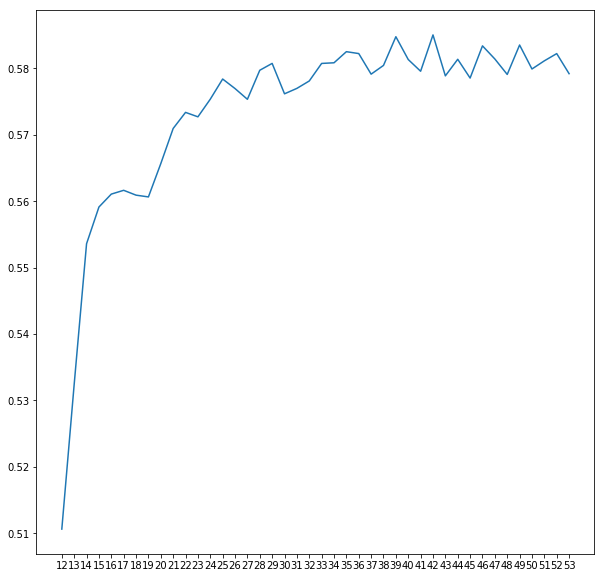

In [149]:
plt.subplots(1, 1, figsize=(10, 10))
plt.xticks(range(0, len(features_scores)), [x[0] for x in features_scores])
plt.plot([x[1] for x in features_scores]);

In [155]:
[x for x in features_scores if x[1] == max([x[1] for x in features_scores])][0]

(42, 0.5850356320066249)

Ahora que cortamos los features de 54 a 42, podemos volver a buscar hiperparámetros que optimicen el nuevo modelo. Si bien esto es un poco recursivo, una vez que llegamos acá estaremos lo suficientemente cerca como para que no valga la pena seguir.

In [156]:
# https://www.kaggle.com/dreeux/hyperparameter-tuning-using-hyperopt
import hyperopt

X_train, Y_train = df[cols], df4['logsalary']
def acc_model(params):
    pipeline = make_pipeline(
        ce.TargetEncoder(cols=cols),
        SelectFromModel(xgboost.XGBRegressor(**params), max_features=42, threshold=-np.inf),
        xgboost.XGBRegressor(**params),
    )
    return cross_val_score(pipeline, X_train, Y_train, cv=5).mean()


best = -1
def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
    print ('params:', params, 'acc: ', acc, 'best', best)
    return {'loss': -acc, 'status': hyperopt.STATUS_OK}

space ={
        'max_depth': hyperopt.hp.choice('max_depth', np.arange(3, 30, dtype=int)),
        'min_child_weight': hyperopt.hp.quniform ('min_child', 1, 20, 1),
        'subsample': hyperopt.hp.uniform ('subsample', 0.4, 0.8),
        'n_estimators' : hyperopt.hp.choice('n_estimators', np.arange(100, 300, 10, dtype=int)),
        'learning_rate' : hyperopt.hp.quniform('learning_rate', 0.025, 0.5, 0.025),
        'gamma' : hyperopt.hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree' : hyperopt.hp.quniform('colsample_bytree', 0.5, 1, 0.05)
    }


trials = hyperopt.Trials()
best = hyperopt.fmin(fn=f,
            space=space,
            algo=hyperopt.tpe.suggest,
            max_evals=100,
            trials=trials)

params: {'gamma': 0.8, 'n_estimators': 120, 'colsample_bytree': 0.65, 'max_depth': 11, 'min_child_weight': 6.0, 'subsample': 0.6775100625988155, 'learning_rate': 0.125} acc:  0.5668144673791911 best 0.5668144673791911
params: {'gamma': 0.55, 'n_estimators': 270, 'colsample_bytree': 0.7000000000000001, 'max_depth': 14, 'min_child_weight': 12.0, 'subsample': 0.423337042887041, 'learning_rate': 0.1} acc:  0.5653410863185214 best 0.5668144673791911
params: {'gamma': 0.6000000000000001, 'n_estimators': 210, 'colsample_bytree': 0.6000000000000001, 'max_depth': 19, 'min_child_weight': 19.0, 'subsample': 0.6680612297871003, 'learning_rate': 0.35000000000000003} acc:  0.5301276118703533 best 0.5668144673791911
params: {'gamma': 0.75, 'n_estimators': 160, 'colsample_bytree': 0.75, 'max_depth': 26, 'min_child_weight': 3.0, 'subsample': 0.7661853037784649, 'learning_rate': 0.42500000000000004} acc:  0.5172205779625907 best 0.5668144673791911
params: {'gamma': 0.8, 'n_estimators': 130, 'colsample_b

params: {'gamma': 0.55, 'n_estimators': 270, 'colsample_bytree': 0.6000000000000001, 'max_depth': 18, 'min_child_weight': 10.0, 'subsample': 0.5905290454017358, 'learning_rate': 0.05} acc:  0.5822624305595963 best 0.5832729191977337
params: {'gamma': 0.5, 'n_estimators': 220, 'colsample_bytree': 0.6000000000000001, 'max_depth': 18, 'min_child_weight': 4.0, 'subsample': 0.408110375906131, 'learning_rate': 0.05} acc:  0.5771707392357417 best 0.5832729191977337
params: {'gamma': 0.55, 'n_estimators': 260, 'colsample_bytree': 1.0, 'max_depth': 18, 'min_child_weight': 10.0, 'subsample': 0.5531543964715293, 'learning_rate': 0.25} acc:  0.5324371210237379 best 0.5832729191977337
params: {'gamma': 0.55, 'n_estimators': 240, 'colsample_bytree': 0.7000000000000001, 'max_depth': 23, 'min_child_weight': 5.0, 'subsample': 0.44409084014957356, 'learning_rate': 0.15000000000000002} acc:  0.5504394529942296 best 0.5832729191977337
params: {'gamma': 0.5, 'n_estimators': 250, 'colsample_bytree': 0.65, '

params: {'gamma': 0.55, 'n_estimators': 230, 'colsample_bytree': 0.55, 'max_depth': 23, 'min_child_weight': 16.0, 'subsample': 0.7460131711512644, 'learning_rate': 0.05} acc:  0.5851500514316874 best 0.5851500514316874
params: {'gamma': 0.5, 'n_estimators': 230, 'colsample_bytree': 0.5, 'max_depth': 23, 'min_child_weight': 18.0, 'subsample': 0.7483068811772543, 'learning_rate': 0.07500000000000001} acc:  0.5814224846802636 best 0.5851500514316874
params: {'gamma': 0.55, 'n_estimators': 230, 'colsample_bytree': 0.55, 'max_depth': 23, 'min_child_weight': 16.0, 'subsample': 0.7163989022071924, 'learning_rate': 0.05} acc:  0.5818729140771844 best 0.5851500514316874
params: {'gamma': 0.65, 'n_estimators': 230, 'colsample_bytree': 0.6000000000000001, 'max_depth': 4, 'min_child_weight': 20.0, 'subsample': 0.6524219691270199, 'learning_rate': 0.025} acc:  0.5649357680252736 best 0.5851500514316874
params: {'gamma': 0.55, 'n_estimators': 220, 'colsample_bytree': 0.55, 'max_depth': 16, 'min_chil

In [108]:
from sklearn.feature_selection import SelectFromModel
import xgboost

X_train, Y_train = df[cols], df4['logsalary']
params = {'gamma': 0.55, 'n_estimators': 230, 'colsample_bytree': 0.55, 'max_depth': 23, 'min_child_weight': 16.0, 'subsample': 0.7460131711512644, 'learning_rate': 0.05}
d
features_scores = []
pipeline = make_pipeline(
    ce.TargetEncoder(cols=cols),
    SelectFromModel(xgboost.XGBRegressor(**params), max_features=42, threshold=-np.inf),
    xgboost.XGBRegressor(**params),
)
cross_val_score(pipeline, X_train, Y_train, cv=5).mean()

/home/sebastianwaisbrot/.local/share/virtualenvs/sysarmy-sueldos-b5vDcW_P/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sebastianwaisbrot/.local/share/virtualenvs/sysarmy-sueldos-b5vDcW_P/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sebastianwaisbrot/.local/share/virtualenvs/sysarmy-sueldos-b5vDcW_P/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sebastianwaisbrot/.local/share/virtualenvs/sysarmy-sueldos-b5vDcW_P/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None

0.5833333107131544

In [109]:
pipeline.fit(X_train, Y_train)

/home/sebastianwaisbrot/.local/share/virtualenvs/sysarmy-sueldos-b5vDcW_P/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sebastianwaisbrot/.local/share/virtualenvs/sysarmy-sueldos-b5vDcW_P/lib/python3.5/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/home/sebastianwaisbrot/.local/share/virtualenvs/sysarmy-sueldos-b5vDcW_P/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sebastianwaisbrot/.local/share/virtualenvs/sysarmy-sueldos-b5vDcW_P/lib/python3.5/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None

Pipeline(memory=None,
     steps=[('targetencoder', TargetEncoder(cols=['Me identifico', 'Tengo', 'Dónde estás trabajando', '¿Gente a cargo?', 'Carrera', 'Universidad', 'Realizaste cursos de especialización', '¿Contribuís a proyectos open source?', '¿Programás como hobbie?', 'Trabajo de', '¿Qué SO usás en tu laptop/PC para tr...    reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.7460131711512644))])

In [110]:
import pickle
with open('../models/xgb.pkl', 'wb') as fp:
    fp.write(pickle.dumps(pipeline))

In [111]:
finalcols = np.array(cols)[pipeline.steps[1][1].get_support()]
finalcols

array(['Me identifico', 'Tengo', 'Dónde estás trabajando',
       '¿Gente a cargo?', 'Carrera', 'Universidad',
       'Realizaste cursos de especialización',
       '¿Contribuís a proyectos open source?', 'Trabajo de',
       '¿Qué SO usás en tu laptop/PC para trabajar?', '¿Y en tu celular?',
       'Tipo de contrato',
       '¿Sufriste o presenciaste situaciones de violencia laboral?',
       'Orientación sexual', 'Cantidad de empleados',
       'Actividad principal', 'years_exp', 'years_company', 'studied',
       'is_windows', 'is_lambda', 'is_vmware', 'is_containers',
       'is_cloud', 'is_other', 'is_backend', 'is_frontend', 'is_.net',
       'is_mobile_fw', 'is_frontend_fw', 'is_cms', 'is_backend_fw',
       'is_sql', 'is_nosql', 'is_NetBeans', 'is_Vi', 'is_Eclipse',
       'is_IntelliJ', 'is_Vim', 'is_Notepad++', 'is_Sublime Text',
       'is_Visual Studio'], dtype='<U58')

In [113]:
X_train, Y_train = df[cols], df4['logsalary']
params = {'gamma': 0.55, 'n_estimators': 230, 'colsample_bytree': 0.55, 'max_depth': 23, 'min_child_weight': 16.0, 'subsample': 0.7460131711512644, 'learning_rate': 0.05}
d
pipeline = make_pipeline(
    ce.TargetEncoder(cols=finalcols),
    xgboost.XGBRegressor(**params),
)
cross_val_score(pipeline, X_train[finalcols], Y_train, cv=5).mean()

/home/sebastianwaisbrot/.local/share/virtualenvs/sysarmy-sueldos-b5vDcW_P/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sebastianwaisbrot/.local/share/virtualenvs/sysarmy-sueldos-b5vDcW_P/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sebastianwaisbrot/.local/share/virtualenvs/sysarmy-sueldos-b5vDcW_P/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sebastianwaisbrot/.local/share/virtualenvs/sysarmy-sueldos-b5vDcW_P/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None

0.5793209722092972

In [114]:
pipeline.fit(X_train[finalcols], Y_train)

import pickle
with open('../models/xgb.pkl', 'wb') as fp:
    fp.write(pickle.dumps(pipeline))

/home/sebastianwaisbrot/.local/share/virtualenvs/sysarmy-sueldos-b5vDcW_P/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sebastianwaisbrot/.local/share/virtualenvs/sysarmy-sueldos-b5vDcW_P/lib/python3.5/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [116]:
import sklearn
knn_pipeline = make_pipeline(
    ce.TargetEncoder(cols=finalcols),
    sklearn.neighbors.KNeighborsRegressor(n_neighbors=39, weights='distance'),
)

In [117]:
cross_val_score(knn_pipeline, X_train[finalcols], Y_train, cv=5).mean()

0.5269337003930771

In [118]:
knn_pipeline.fit(X_train[finalcols], Y_train)

import pickle
with open('../models/knn.pkl', 'wb') as fp:
    fp.write(pickle.dumps(knn_pipeline))

In [121]:
df['Realizaste cursos de especialización'].value_counts()

Sí, de forma particular                                   1881
No                                                        1188
Sí, de forma particular, Sí, los pagó un empleador         871
Sí, los pagó un empleador                                  519
No, Sí, de forma particular                                  7
No, Sí, los pagó un empleador                                2
No, Sí, de forma particular, Sí, los pagó un empleador       1
Name: Realizaste cursos de especialización, dtype: int64